Описание данных:
  ptbxl_database.csv - исходный датасет для анализа. 
  Основные атрибуты: возраст, пол, рост, вес, код диагноза и подклассы диагнозов

  scp_statements.csv - словарь кодов диагнозов с подклассами.

Значения классов:

NORM: Нормальная ЭКГ

MI: Инфаркт миокарда, инфаркт миокарда (ИМ), широко известный как сердечный приступ, возникает, когда поток крови уменьшается или прекращается в части сердца, вызывая повреждение сердечной мышцы.

STTC: Изменение ST/T. Изменения зубцов ST и T могут указывать на сердечную патологию или быть вариантом нормы. Таким образом, интерпретация результатов зависит от клинического контекста и наличия аналогичных результатов на предыдущих электрокардиограммах.

CD: Conduction Disturbance. Ваш сердечный ритм – это то, как бьется ваше сердце. Проводимость – это то, как электрические импульсы проходят через ваше сердце, заставляя его биться. Некоторые нарушения проводимости могут вызывать аритмии или нерегулярное сердцебиение.

HYP: Гипертрофия. Гипертрофическая кардиомиопатия (ГКМП) — заболевание, при котором сердечная мышца становится аномально толстой (гипертрофированной). Утолщенная сердечная мышца может затруднить перекачку крови сердцу.

In [99]:
!pip install wfdb

In [101]:
import pandas as pd
import numpy as np
import wfdb
import ast
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [103]:
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = './dataset/'
sampling_rate=500

# Загрузка аннотационных данных
df = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))



In [105]:
df.describe(include='all')

patient_id           age           sex       height       weight  \
count   21799.000000  21799.000000  21799.000000  6974.000000  9421.000000   
unique           NaN           NaN           NaN          NaN          NaN   
top              NaN           NaN           NaN          NaN          NaN   
freq             NaN           NaN           NaN          NaN          NaN   
mean    11250.156521     62.769301      0.479150   166.702323    70.995223   
std      6235.026404     32.308813      0.499577    10.867321    15.878803   
min       302.000000      2.000000      0.000000     6.000000     5.000000   
25%      5974.500000     50.000000      0.000000   160.000000    60.000000   
50%     11419.000000     62.000000      0.000000   166.000000    70.000000   
75%     16607.500000     72.000000      1.000000   174.000000    80.000000   
max     21797.000000    300.000000      1.000000   209.000000   250.000000   

               nurse          site      device       recording_date  \
count   20326.000000  21782.000000       21799                21799   
unique           NaN           NaN          11                21795   
top              NaN           NaN  CS100    3  1992-02-06 11:47:42   
freq             NaN           NaN        6140                    2   
mean        2.291745      1.544945         NaN                  NaN   
std         3.254033      4.172883         NaN                  NaN   
min         0.000000      0.000000         NaN                  NaN   
25%         0.000000      0.000000         NaN                  NaN   
50%         1.000000      1.000000         NaN                  NaN   
75%         3.000000      2.000000         NaN                  NaN   
max        11.000000     50.000000         NaN                  NaN   

                           report  ... validated_by_human baseline_drift  \
count                       21799  ...              21799           1598   
unique                       9887  ...                  2            317   
top     sinus rhythm. normal ecg.  ...               True           , V6   
freq                         1734  ...              16056            221   
mean                          NaN  ...                NaN            NaN   
std                           NaN  ...                NaN            NaN   
min                           NaN  ...                NaN            NaN   
25%                           NaN  ...                NaN            NaN   
50%                           NaN  ...                NaN            NaN   
75%                           NaN  ...                NaN            NaN   
max                           NaN  ...                NaN            NaN   

       static_noise burst_noise  electrodes_problems extra_beats  \
count          3260         613                   30        1949   
unique          124         103                   14         128   
top      , I-AVR,         alles                   V6         1ES   
freq            953         140                    8         405   
mean            NaN         NaN                  NaN         NaN   
std             NaN         NaN                  NaN         NaN   
min             NaN         NaN                  NaN         NaN   
25%             NaN         NaN                  NaN         NaN   
50%             NaN         NaN                  NaN         NaN   
75%             NaN         NaN                  NaN         NaN   
max             NaN         NaN                  NaN         NaN   

            pacemaker    strat_fold                filename_lr  \
count             291  21799.000000                      21799   
unique              4           NaN                      21799   
top     ja, pacemaker           NaN  records100/00000/00001_lr   
freq              285           NaN                          1   
mean              NaN      5.503005                        NaN   
std               NaN      2.874948                        NaN   
min               NaN      1

In [109]:
def remove_outliers(data, col):
    column = data[col]
    IQR = column.quantile(0.75) - column.quantile(0.25)
    h = column.quantile(0.75) + 1.5 * IQR
    l = column.quantile(0.25) - 1.5 * IQR
    return data[column.between(l, h)]
    
def remove_outer_interval(data, col, low_value, max_value):
    column = data[col]
    return data[column.between(low_value, max_value)]    

In [111]:
df = remove_outer_interval(df, "age", 5, 100)

In [113]:
df.describe(include='all')

patient_id           age           sex       height       weight  \
count   21501.000000  21501.000000  21501.000000  6812.000000  9263.000000   
unique           NaN           NaN           NaN          NaN          NaN   
top              NaN           NaN           NaN          NaN          NaN   
freq             NaN           NaN           NaN          NaN          NaN   
mean    11289.710665     59.550346      0.475141   166.860393    71.249703   
std      6224.143201     16.738679      0.499393    10.773875    15.772341   
min       302.000000      5.000000      0.000000     6.000000     5.000000   
25%      6053.000000     50.000000      0.000000   160.000000    60.000000   
50%     11466.000000     61.000000      0.000000   166.000000    70.000000   
75%     16636.000000     72.000000      1.000000   174.000000    80.000000   
max     21797.000000     89.000000      1.000000   209.000000   250.000000   

               nurse          site      device       recording_date  \
count   20056.000000  21486.000000       21501                21501   
unique           NaN           NaN          11                21497   
top              NaN           NaN  CS100    3  2000-08-08 09:34:05   
freq             NaN           NaN        6133                    2   
mean        2.270193      1.533976         NaN                  NaN   
std         3.246346      4.170682         NaN                  NaN   
min         0.000000      0.000000         NaN                  NaN   
25%         0.000000      0.000000         NaN                  NaN   
50%         1.000000      1.000000         NaN                  NaN   
75%         3.000000      2.000000         NaN                  NaN   
max        11.000000     50.000000         NaN                  NaN   

                           report  ... validated_by_human baseline_drift  \
count                       21501  ...              21501           1570   
unique                       9670  ...                  2            312   
top     sinus rhythm. normal ecg.  ...               True           , V6   
freq                         1728  ...              15761            216   
mean                          NaN  ...                NaN            NaN   
std                           NaN  ...                NaN            NaN   
min                           NaN  ...                NaN            NaN   
25%                           NaN  ...                NaN            NaN   
50%                           NaN  ...                NaN            NaN   
75%                           NaN  ...                NaN            NaN   
max                           NaN  ...                NaN            NaN   

       static_noise burst_noise  electrodes_problems extra_beats  \
count          3215         603                   29        1898   
unique          122         102                   14         128   
top      , I-AVR,         alles                   V6         1ES   
freq            941         140                    8         390   
mean            NaN         NaN                  NaN         NaN   
std             NaN         NaN                  NaN         NaN   
min             NaN         NaN                  NaN         NaN   
25%             NaN         NaN                  NaN         NaN   
50%             NaN         NaN                  NaN         NaN   
75%             NaN         NaN                  NaN         NaN   
max             NaN         NaN                  NaN         NaN   

            pacemaker    strat_fold                filename_lr  \
count             283  21501.000000                      21501   
unique              4           NaN                      21501   
top     ja, pacemaker           NaN  records100/00000/00001_lr   
freq              278           NaN                          1   
mean              NaN      5.498907                        NaN   
std               NaN      2.873692                        NaN   
min               NaN      1

In [115]:
df.shape

(21501, 27)

In [117]:
# Загрузка сигнальных данных
x_raw_data = load_raw_data(df, sampling_rate, path)
scp_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
scp_df = scp_df[scp_df.diagnostic == 1]

def make_super_class(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in scp_df.index:
            tmp.append(scp_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Создание колонки списка классов диагнозов
df['scp_superclass'] = df.scp_codes.apply(make_super_class)

In [261]:
df.head(5)

patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1            15709  56.0    1     NaN    63.0      2     0  CS-12   E   
2            13243  19.0    0     NaN    70.0      2     0  CS-12   E   
3            20372  37.0    1     NaN    69.0      2     0  CS-12   E   
4            17014  24.0    0     NaN    82.0      2     0  CS-12   E   
5            17448  19.0    1     NaN    70.0      2     0  CS-12   E   

             recording_date                                  report  \
ecg_id                                                                
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg   
5       1984-11-17 10:43:15              sinusrhythmus normales ekg   

                                       scp_codes heart_axis  \
ecg_id                                                        
1       {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}        NaN   
2                   {'NORM': 80.0, 'SBRAD': 0.0}        NaN   
3                     {'NORM': 100.0, 'SR': 0.0}        NaN   
4                     {'NORM': 100.0, 'SR': 0.0}        NaN   
5                     {'NORM': 100.0, 'SR': 0.0}        NaN   

       infarction_stadium1 infarction_stadium2  validated_by  second_opinion  \
ecg_id                                                                         
1                      NaN                 NaN          <NA>           False   
2                      NaN                 NaN          <NA>           False   
3                      NaN                 NaN          <NA>           False   
4                      NaN                 NaN          <NA>           False   
5                      NaN                 NaN          <NA>           False   

        initial_autogenerated_report  validated_by_human  baseline_drift  \
ecg_id                                                                     
1                              False                True             NaN   
2                              False                True             NaN   
3                              False                True             NaN   
4                              False                True    , II,III,AVF   
5                              False                True   , III,AVR,AVF   

       static_noise burst_noise electrodes_problems extra_beats pacemaker  \
ecg_id                                                                      
1         , I-V1,           NaN                 NaN         NaN       NaN   
2               NaN         NaN                 NaN         NaN       NaN   
3               NaN         NaN                 NaN         NaN       NaN   
4               NaN         NaN                 NaN         NaN       NaN   
5               NaN         NaN                 NaN         NaN       NaN   

        strat_fold                filename_lr                filename_hr  \
ecg_id                                                                     
1                3  records100/00000/00001_lr  records500/00000/00001_hr   
2                2  records100/00000/00002_lr  records500/00000/00002_hr   
3                5  records100/00000/00003_lr  records500/00000/00003_hr   
4                3  records100/00000/00004_lr  records500/00000/00004_hr   
5                4  records100/00000/00005_lr  records500/00000/00005_hr   

       scp_superclass  scp_superclass_len scp_subclass  scp_subclass_len  
ecg_id                                                                    
1              [NORM]                   1   [sub_NORM]                 1  
2              [NORM]                   1   [sub_NORM]                 1  
3              [NORM]                   1   [sub_NORM]                 1  
4             

Проверим количествло записей без диагноза

In [269]:
df[(df["scp_superclass_len"])==0].shape

(403, 31)

Отобразим матрицу сигналов с ЭКГ

In [182]:
display(x_raw_data.shape)
x_raw_data

(21501, 5000, 12)

array([[[-0.115, -0.05 ,  0.065, ..., -0.035, -0.035, -0.075],
        [-0.115, -0.05 ,  0.065, ..., -0.035, -0.035, -0.075],
        [-0.115, -0.05 ,  0.065, ..., -0.035, -0.035, -0.075],
        ...,
        [ 0.21 ,  0.205, -0.005, ...,  0.185,  0.17 ,  0.18 ],
        [ 0.21 ,  0.205, -0.005, ...,  0.185,  0.17 ,  0.18 ],
        [ 0.21 ,  0.205, -0.005, ...,  0.185,  0.17 ,  0.18 ]],

       [[-0.015,  0.12 ,  0.135, ...,  0.16 ,  0.06 ,  0.065],
        [-0.015,  0.12 ,  0.135, ...,  0.16 ,  0.06 ,  0.065],
        [-0.015,  0.12 ,  0.135, ...,  0.16 ,  0.06 ,  0.065],
        ...,
        [-0.055,  0.015,  0.07 , ..., -0.215, -0.195, -0.13 ],
        [-0.055,  0.015,  0.07 , ..., -0.215, -0.195, -0.13 ],
        [-0.055,  0.015,  0.07 , ..., -0.215, -0.195, -0.13 ]],

       [[-0.035, -0.07 , -0.035, ..., -0.1  , -0.075, -0.065],
        [-0.035, -0.07 , -0.035, ..., -0.1  , -0.075, -0.065],
        [-0.035, -0.07 , -0.035, ..., -0.1  , -0.075, -0.065],
        ...,
        [-0.

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21501 entries, 1 to 21837
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21501 non-null  float64
 1   age                           21501 non-null  float64
 2   sex                           21501 non-null  int64  
 3   height                        6812 non-null   float64
 4   weight                        9263 non-null   float64
 5   nurse                         20056 non-null  float64
 6   site                          21486 non-null  float64
 7   device                        21501 non-null  object 
 8   recording_date                21501 non-null  object 
 9   report                        21501 non-null  object 
 10  scp_codes                     21501 non-null  object 
 11  heart_axis                    13167 non-null  object 
 12  infarction_stadium1           5489 non-null   object 
 13  infarc

In [128]:
df.patient_id = df.patient_id.astype(int)
df.validated_by = df.validated_by.astype('Int64')
df.nurse = df.nurse.astype('Int64')
df.site = df.site.astype('Int64')

In [130]:
df.describe(include='all')

patient_id           age           sex       height       weight  \
count   21501.000000  21501.000000  21501.000000  6812.000000  9263.000000   
unique           NaN           NaN           NaN          NaN          NaN   
top              NaN           NaN           NaN          NaN          NaN   
freq             NaN           NaN           NaN          NaN          NaN   
mean    11289.710665     59.550346      0.475141   166.860393    71.249703   
std      6224.143201     16.738679      0.499393    10.773875    15.772341   
min       302.000000      5.000000      0.000000     6.000000     5.000000   
25%      6053.000000     50.000000      0.000000   160.000000    60.000000   
50%     11466.000000     61.000000      0.000000   166.000000    70.000000   
75%     16636.000000     72.000000      1.000000   174.000000    80.000000   
max     21797.000000     89.000000      1.000000   209.000000   250.000000   

           nurse      site      device       recording_date  \
count    20056.0   21486.0       21501                21501   
unique      <NA>      <NA>          11                21497   
top         <NA>      <NA>  CS100    3  2000-08-08 09:34:05   
freq        <NA>      <NA>        6133                    2   
mean    2.270193  1.533976         NaN                  NaN   
std     3.246346  4.170682         NaN                  NaN   
min          0.0       0.0         NaN                  NaN   
25%          0.0       0.0         NaN                  NaN   
50%          1.0       1.0         NaN                  NaN   
75%          3.0       2.0         NaN                  NaN   
max         11.0      50.0         NaN                  NaN   

                           report  ... baseline_drift static_noise  \
count                       21501  ...           1570         3215   
unique                       9670  ...            312          122   
top     sinus rhythm. normal ecg.  ...           , V6   , I-AVR,     
freq                         1728  ...            216          941   
mean                          NaN  ...            NaN          NaN   
std                           NaN  ...            NaN          NaN   
min                           NaN  ...            NaN          NaN   
25%                           NaN  ...            NaN          NaN   
50%                           NaN  ...            NaN          NaN   
75%                           NaN  ...            NaN          NaN   
max                           NaN  ...            NaN          NaN   

       burst_noise electrodes_problems  extra_beats      pacemaker  \
count          603                  29         1898            283   
unique         102                  14          128              4   
top          alles                  V6          1ES  ja, pacemaker   
freq           140                   8          390            278   
mean           NaN                 NaN          NaN            NaN   
std            NaN                 NaN          NaN            NaN   
min            NaN                 NaN          NaN            NaN   
25%            NaN                 NaN          NaN            NaN   
50%            NaN                 NaN          NaN            NaN   
75%            NaN                 NaN          NaN            NaN   
max            NaN                 NaN          NaN            NaN   

          strat_fold                filename_lr                filename_hr  \
count   21501.000000                      21501                      21501   
unique           NaN                      21501                      21501   
top              NaN  records100/00000/00001_lr  records500/00000/00001_hr   
freq             NaN                          1                          1   
mean        5.498907                        NaN                        NaN   
std         2.873692                        NaN                        NaN   
min         1.000000                        NaN                        NaN   
25%       

In [132]:
scp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, NDT to 2AVB
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   description                    44 non-null     object 
 1   diagnostic                     44 non-null     float64
 2   form                           4 non-null      float64
 3   rhythm                         0 non-null      float64
 4   diagnostic_class               44 non-null     object 
 5   diagnostic_subclass            44 non-null     object 
 6   Statement Category             44 non-null     object 
 7   SCP-ECG Statement Description  44 non-null     object 
 8   AHA code                       22 non-null     float64
 9   aECG REFID                     12 non-null     object 
 10  CDISC Code                     13 non-null     object 
 11  DICOM Code                     9 non-null      object 
dtypes: float64(4), object(8)
memory usage: 5.5+ KB


In [134]:
# Загружаем scp_statements.csv который содержит аббревиатуры и расшифровки диагнозов
print(scp_df.shape)
scp_df.head()

(44, 12)


description  diagnostic  form  rhythm  \
NDT    non-diagnostic T abnormalities         1.0   1.0     NaN   
NST_          non-specific ST changes         1.0   1.0     NaN   
DIG                  digitalis-effect         1.0   1.0     NaN   
LNGQT                long QT-interval         1.0   1.0     NaN   
NORM                       normal ECG         1.0   NaN     NaN   

      diagnostic_class diagnostic_subclass  \
NDT               STTC                STTC   
NST_              STTC                NST_   
DIG               STTC                STTC   
LNGQT             STTC                STTC   
NORM              NORM                NORM   

                                      Statement Category  \
NDT                    other ST-T descriptive statements   
NST_   Basic roots for coding ST-T changes and abnorm...   
DIG                    other ST-T descriptive statements   
LNGQT                  other ST-T descriptive statements   
NORM                                     Normal/abnormal   

        SCP-ECG Statement Description  AHA code            aECG REFID  \
NDT    non-diagnostic T abnormalities       NaN                   NaN   
NST_          non-specific ST changes     145.0  MDC_ECG_RHY_STHILOST   
DIG         suggests digitalis-effect     205.0                   NaN   
LNGQT                long QT-interval     148.0                   NaN   
NORM                       normal ECG       1.0                   NaN   

      CDISC Code DICOM Code  
NDT          NaN        NaN  
NST_         NaN        NaN  
DIG          NaN        NaN  
LNGQT        NaN        NaN  
NORM         NaN    F-000B7

Основными колонками для нас являются diagnostic_class и diagnostic_subclass, которые определяют диагностические классы и подклассы. diagnostic_class содержит варианты значений целевой переменной.

In [137]:
df['scp_superclass_len'] = df['scp_superclass'].apply(len)
df.loc[df.scp_superclass_len > 1, 'scp_superclass']

ecg_id
39       [STTC, MI]
45        [CD, HYP]
50         [CD, MI]
77         [CD, MI]
87       [CD, STTC]
            ...    
21815      [CD, MI]
21821    [NORM, CD]
21827    [STTC, MI]
21828    [STTC, MI]
21829    [NORM, CD]
Name: scp_superclass, Length: 4997, dtype: object

In [139]:
df

patient_id   age  sex  height  weight  nurse  site      device  \
ecg_id                                                                   
1            15709  56.0    1     NaN    63.0      2     0   CS-12   E   
2            13243  19.0    0     NaN    70.0      2     0   CS-12   E   
3            20372  37.0    1     NaN    69.0      2     0   CS-12   E   
4            17014  24.0    0     NaN    82.0      2     0   CS-12   E   
5            17448  19.0    1     NaN    70.0      2     0   CS-12   E   
...            ...   ...  ...     ...     ...    ...   ...         ...   
21832         7954  63.0    0     NaN     NaN      1     2  AT-60    3   
21833        17180  67.0    1     NaN     NaN      1     2  AT-60    3   
21835        19311  59.0    1     NaN     NaN      1     2  AT-60    3   
21836         8873  64.0    1     NaN     NaN      1     2  AT-60    3   
21837        11744  68.0    0     NaN     NaN      1     2  AT-60    3   

             recording_date  \
ecg_id                        
1       1984-11-09 09:17:34   
2       1984-11-14 12:55:37   
3       1984-11-15 12:49:10   
4       1984-11-15 13:44:57   
5       1984-11-17 10:43:15   
...                     ...   
21832   2001-05-30 14:14:25   
21833   2001-05-31 09:14:35   
21835   2001-06-08 10:30:27   
21836   2001-06-09 18:21:49   
21837   2001-06-11 16:43:01   

                                                   report  ... static_noise  \
ecg_id                                                     ...                
1                  sinusrhythmus periphere niederspannung  ...    , I-V1,     
2                     sinusbradykardie sonst normales ekg  ...          NaN   
3                              sinusrhythmus normales ekg  ...          NaN   
4                              sinusrhythmus normales ekg  ...          NaN   
5                              sinusrhythmus normales ekg  ...          NaN   
...                                                   ...  ...          ...   
21832   sinusrhythmus linkstyp periphere niederspannun...  ...          NaN   
21833   ventrikulÄre extrasystole(n) sinustachykardie ...  ...   , alles,     
21835   sinusrhythmus lagetyp normal t abnorm in anter...  ...   , I-AVR,     
21836   supraventrikulÄre extrasystole(n) sinusrhythmu...  ...          NaN   
21837   sinusrhythmus p-sinistrocardiale lagetyp norma...  ...   , I-AVL,     

       burst_noise electrodes_problems extra_beats  pacemaker  strat_fold  \
ecg_id                                                                      
1              NaN                 NaN         NaN        NaN           3   
2              NaN                 NaN         NaN        NaN           2   
3              NaN                 NaN         NaN        NaN           5   
4              NaN                 NaN         NaN        NaN           3   
5              NaN                 NaN         NaN        NaN           4   
...            ...                 ...         ...        ...         ...   
21832          NaN                 NaN         NaN        NaN           7   
21833          NaN                 NaN         1ES        NaN           7   
21835          NaN                 NaN         NaN        NaN           2   
21836          NaN                 NaN        SVES        NaN           8   
21837          NaN                 NaN         NaN        NaN           9   

                      filename_lr                filename_hr scp_superclass  \
ecg_id                                                                        
1       records100/00000/00001_lr  records500/00000/00001_hr         [NORM]   
2       records100/00000/00002_lr  records500/00000/00002_hr         [NORM]   
3       records100/00000/00003_lr  records500/00000/00003_hr         [NORM]   
4       records100/00000/00004_lr  records500/00000/00004_hr         [NORM]   
5       records100/00000/00005_lr  records500/00000/00005_hr         [NORM]   
...                           ...                        .

In [141]:
# Формируем диагностические подклассы
def make_subclass(scp_dict):
    tmp = []
    for key in scp_dict.keys():
        if key in scp_df.index:
            tmp.append(scp_df.loc[key].diagnostic_subclass)
    ret = list(set(tmp))
    ret = ['sub_'+r for r in ret]
    return ret

# Создаем новые колонки для списка подклассов и длину списка подклассов
df['scp_subclass'] = df.scp_codes.apply(make_subclass)
df['scp_subclass_len'] = df['scp_subclass'].apply(len)
df.loc[df.scp_subclass_len > 1, 'scp_subclass']

ecg_id
26                    [sub_NST_, sub_STTC]
28                    [sub_NST_, sub_STTC]
39           [sub_IMI, sub_NST_, sub_STTC]
45       [sub_IRBBB, sub_RAO/RAE, sub_RVH]
50                     [sub_IVCD, sub_LMI]
                       ...                
21821                [sub_IRBBB, sub_NORM]
21827                  [sub_IMI, sub_ISCA]
21828                  [sub_IMI, sub_ISCA]
21829                [sub_IRBBB, sub_NORM]
21832            [sub_IVCD, sub_LAFB/LPFB]
Name: scp_subclass, Length: 6009, dtype: object

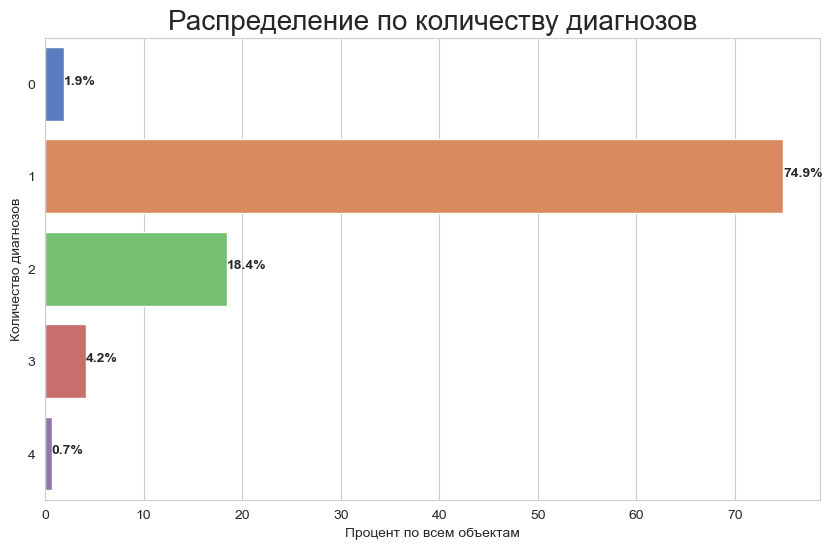

In [143]:
vc = df['scp_superclass_len'].value_counts()

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Распределение по количеству диагнозов", fontsize=20)
ax.set_xlabel ("Процент по всем объектам")
ax.set_ylabel ("Количество диагнозов")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )
plt.show()    

Значения классов:

NORM: Нормальная ЭКГ

MI: Инфаркт миокарда, инфаркт миокарда (ИМ), широко известный как сердечный приступ, возникает, когда поток крови уменьшается или прекращается в части сердца, вызывая повреждение сердечной мышцы.

STTC: Изменение ST/T. Изменения зубцов ST и T могут указывать на сердечную патологию или быть вариантом нормы. Таким образом, интерпретация результатов зависит от клинического контекста и наличия аналогичных результатов на предыдущих электрокардиограммах.

CD: Conduction Disturbance. Ваш сердечный ритм – это то, как бьется ваше сердце. Проводимость – это то, как электрические импульсы проходят через ваше сердце, заставляя его биться. Некоторые нарушения проводимости могут вызывать аритмии или нерегулярное сердцебиение.

HYP: Гипертрофия. Гипертрофическая кардиомиопатия (ГКМП) — заболевание, при котором сердечная мышца становится аномально толстой (гипертрофированной). Утолщенная сердечная мышца может затруднить перекачку крови сердцу.

Строим распределение подклассов диагнозов

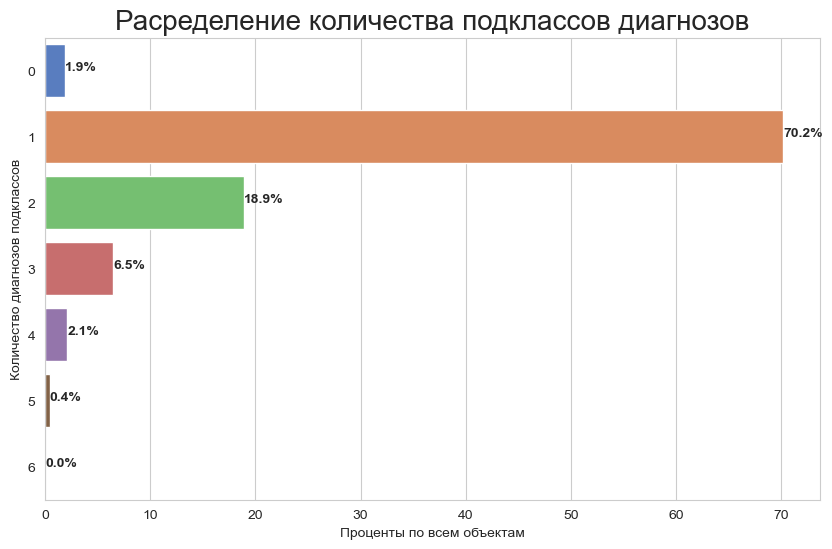

In [147]:

vc = df['scp_subclass_len'].value_counts()

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Расределение количества подклассов диагнозов", fontsize=20)
ax.set_xlabel ("Проценты по всем объектам")
ax.set_ylabel ("Количество диагнозов подклассов")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )
plt.show()     

Создаем ряда суперкласса, подкласса диагнозов.
Фомируем ряд имено новых колонок данных.

In [150]:
all_superclass = pd.Series(np.concatenate(df['scp_superclass'].values))
all_subclass = pd.Series(np.concatenate(df['scp_subclass'].values))
superclass_cols = all_superclass.unique()
subclass_cols = all_subclass.unique()
update_cols = np.concatenate([superclass_cols, subclass_cols])
meta_cols = ['age', 'nurse', 'site', 'device', 'sex', 'height', 'weight']

Создаем новый датафрейм для анализа подклассов диагнозов

In [153]:
class SetterClasses():
    def __init__(self, cols):
        self.cols = cols

    def __call__(self, row):
        for sc in row['scp_superclass']:
            row[sc] = 1
        for sc in row['scp_subclass']:
            row[sc] = 1
            
        return row

def data_by_folds(folds, signal_data, y, update_cols, feature_cols):
    filt = np.isin(y.strat_fold.values, folds)
    x_selected = signal_data[filt]
    y_selected = y[filt]
    print(filt)
    
    for sc in update_cols:
        y_selected[sc] = 0
        
    cls_updt = SetterClasses(update_cols)    
    y_selected = y_selected.apply(cls_updt, axis=1)    
    return x_selected, y_selected[list(feature_cols)+list(update_cols)+['strat_fold']]

In [155]:
x_fold, y_fold = data_by_folds(np.arange(1, 11), x_raw_data, df, update_cols, meta_cols)

[ True  True  True ...  True  True  True]


In [184]:
display(y_fold)

age nurse site      device  sex  height  weight  NORM  MI  STTC  ...  \
ecg_id                                                                    ...   
1       56.0     2    0   CS-12   E    1     NaN    63.0     1   0     0  ...   
2       19.0     2    0   CS-12   E    0     NaN    70.0     1   0     0  ...   
3       37.0     2    0   CS-12   E    1     NaN    69.0     1   0     0  ...   
4       24.0     2    0   CS-12   E    0     NaN    82.0     1   0     0  ...   
5       19.0     2    0   CS-12   E    1     NaN    70.0     1   0     0  ...   
...      ...   ...  ...         ...  ...     ...     ...   ...  ..   ...  ...   
21832   63.0     1    2  AT-60    3    0     NaN     NaN     0   0     0  ...   
21833   67.0     1    2  AT-60    3    1     NaN     NaN     0   0     1  ...   
21835   59.0     1    2  AT-60    3    1     NaN     NaN     0   0     1  ...   
21836   64.0     1    2  AT-60    3    1     NaN     NaN     1   0     0  ...   
21837   68.0     1    2  AT-60    3    0     NaN     NaN     1   0     0  ...   

        sub_SEHYP  sub_ISCI  sub_ISC_  sub_CRBBB  sub_CLBBB  sub_LAO/LAE  \
ecg_id                                                                     
1               0         0         0          0          0            0   
2               0         0         0          0          0            0   
3               0         0         0          0          0            0   
4               0         0         0          0          0            0   
5               0         0         0          0          0            0   
...           ...       ...       ...        ...        ...          ...   
21832           0         0         0          0          0            0   
21833           0         0         0          0          0            0   
21835           0         0         0          0          0            0   
21836           0         0         0          0          0            0   
21837           0         0         0          0          0            0   

        sub_ILBBB  sub_PMI  sub_WPW  strat_fold  
ecg_id                                           
1               0        0        0           3  
2               0        0        0           2  
3               0        0        0           5  
4               0        0        0           3  
5               0        0        0           4  
...           ...      ...      ...         ...  
21832           0        0        0           7  
21833           0        0        0           7  
21835           0        0        0           2  
21836           0        0        0           8  
21837           0        0        0           9  

[21501 rows x 36 columns]

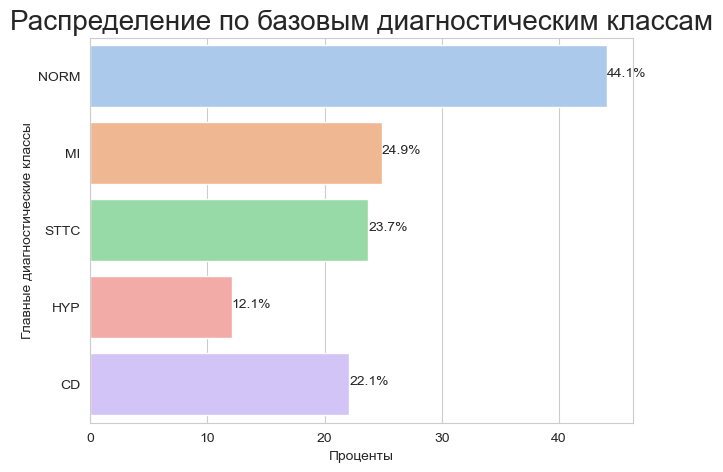

In [186]:
sub_col_sum = y_fold[superclass_cols].sum(axis=0)
bar,ax = plt.subplots(figsize=(7,5))
ax = sns.barplot(x=sub_col_sum.values/y_fold.shape[0]*100., y=sub_col_sum.index, ci=None, palette="pastel", orient='h')
ax.set_title("Распределение по базовым диагностическим классам", fontsize=20)
ax.set_ylabel ("Главные диагностические классы")
ax.set_xlabel ("Проценты")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width() )
plt.show()    

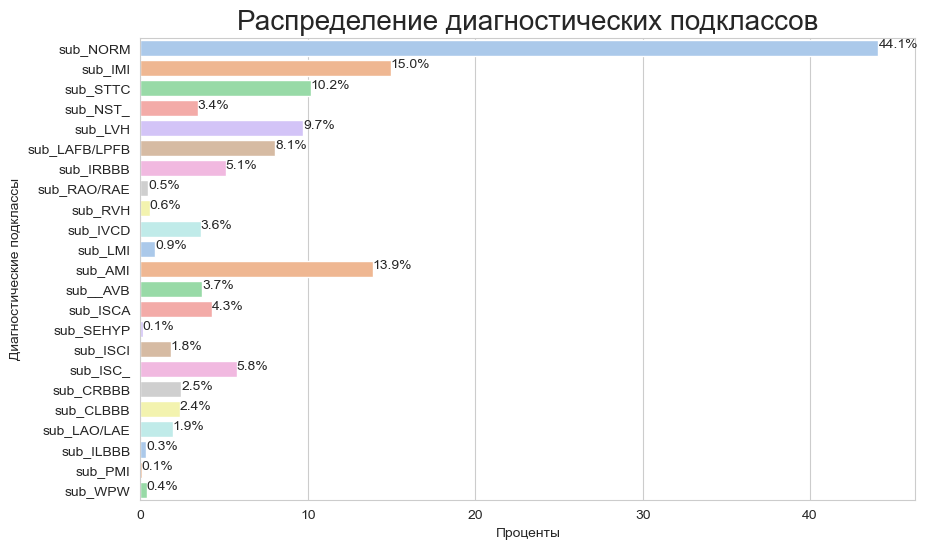

In [188]:
sub_col_sum = y_fold[subclass_cols].sum(axis=0)

bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x = sub_col_sum.values / y_fold.shape[0] * 100., y=sub_col_sum.index, palette="pastel", orient='h')
ax.set_title("Распределение диагностических подклассов", fontsize=20)
ax.set_xlabel ("Проценты")
ax.set_ylabel ("Диагностические подклассы")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width())
plt.show()    

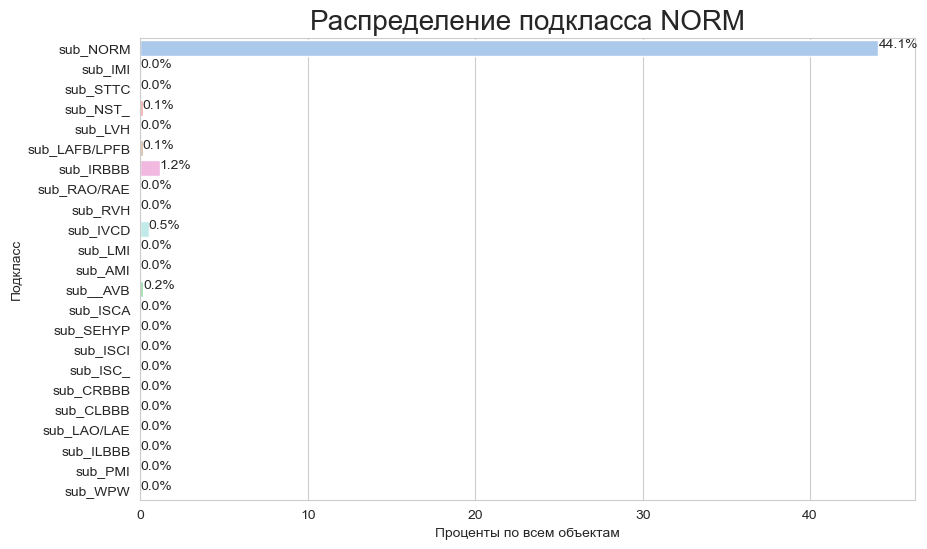

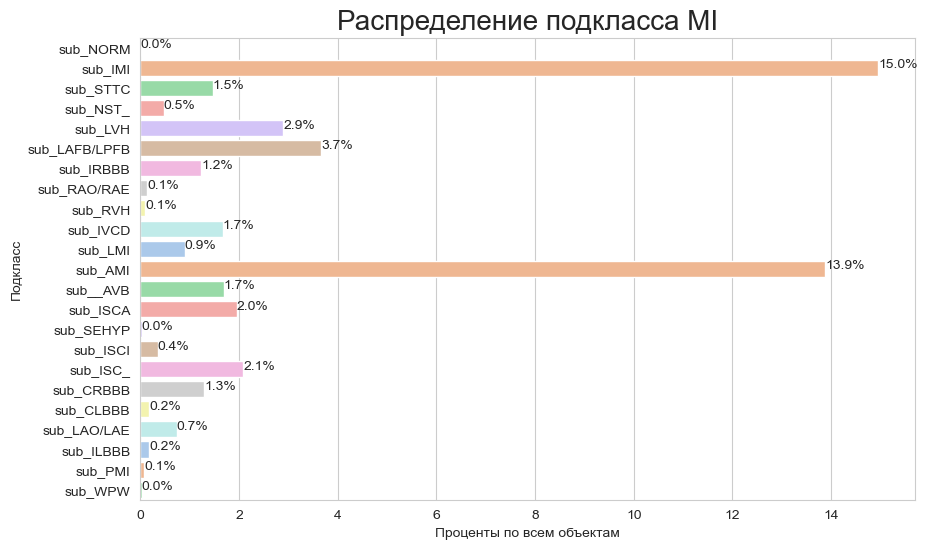

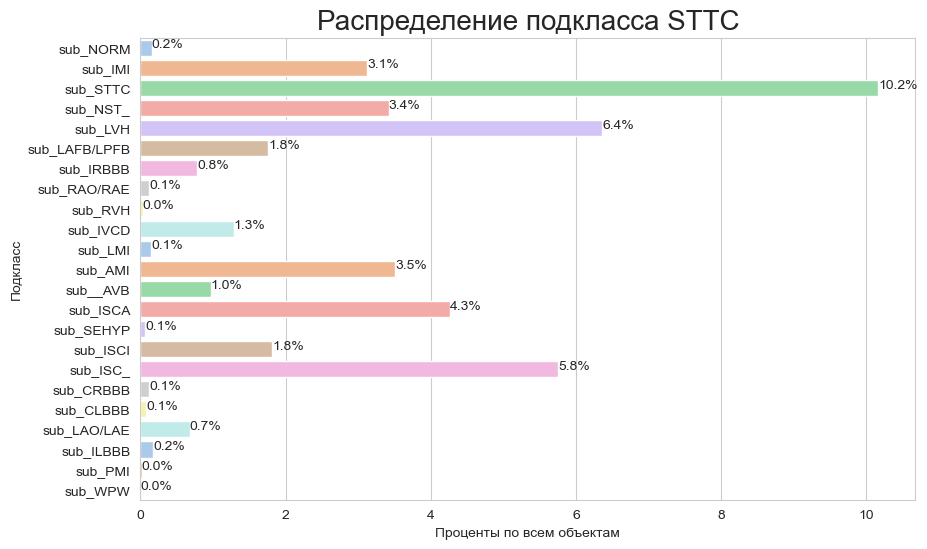

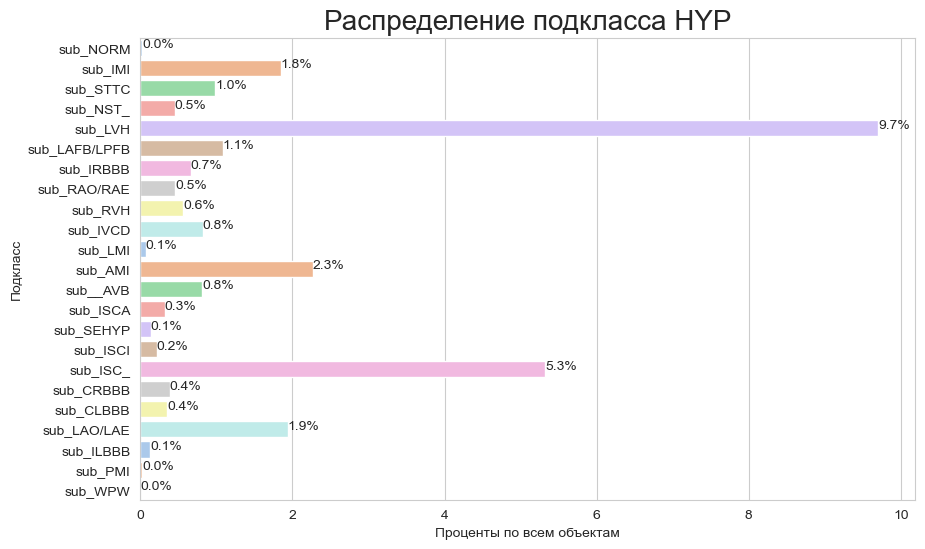

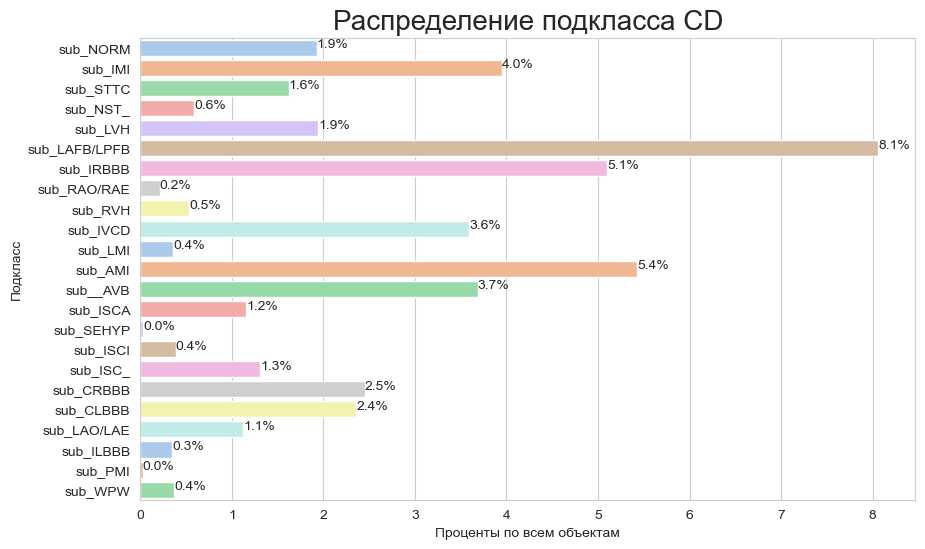

In [190]:
for superclass in superclass_cols:    
    sub_col_sum = y_fold.loc[y_fold[superclass] == 1][subclass_cols].sum(axis=0)    
    bar,ax = plt.subplots(figsize=(10,6))
    ax = sns.barplot(x=sub_col_sum.values / y_fold.shape[0] * 100., y= sub_col_sum.index, palette="pastel",orient='h')
    ax.set_title("Распределение подкласса {}".format(superclass), fontsize=20)
    ax.set_xlabel ("Проценты по всем объектам")
    ax.set_ylabel ("Подкласс")
    for rect in ax.patches:
        ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width())
plt.show()        

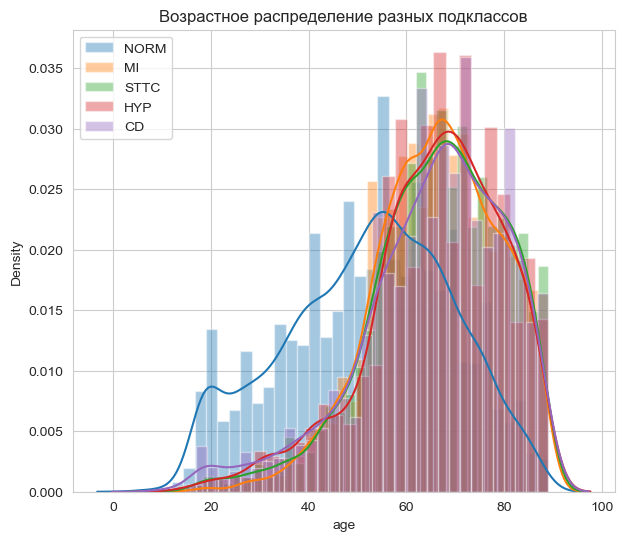

In [192]:
fig, ax = plt.subplots(figsize=(7,6))
plt.title('Возрастное распределение разных подклассов')
for superclass in superclass_cols:
    data = y_fold.loc[y_fold[superclass] == 1]['age']   
    sns.distplot(data, label=superclass)
plt.legend(loc='upper left')
plt.show()

Из диаграммы видно, что пик нормального состояния приходится примерно на 50 лет. После он начинает уменьшаться.
Пик категрии MI (инфаркт миакарда), HYP (Гипертония), CD (Нарушение сердечной проводимости), STTC (изменение ST сегмента) приходится на 65 лет.

Отобразим несколько примеров сырых данных полученных от аппарата ЭКГ

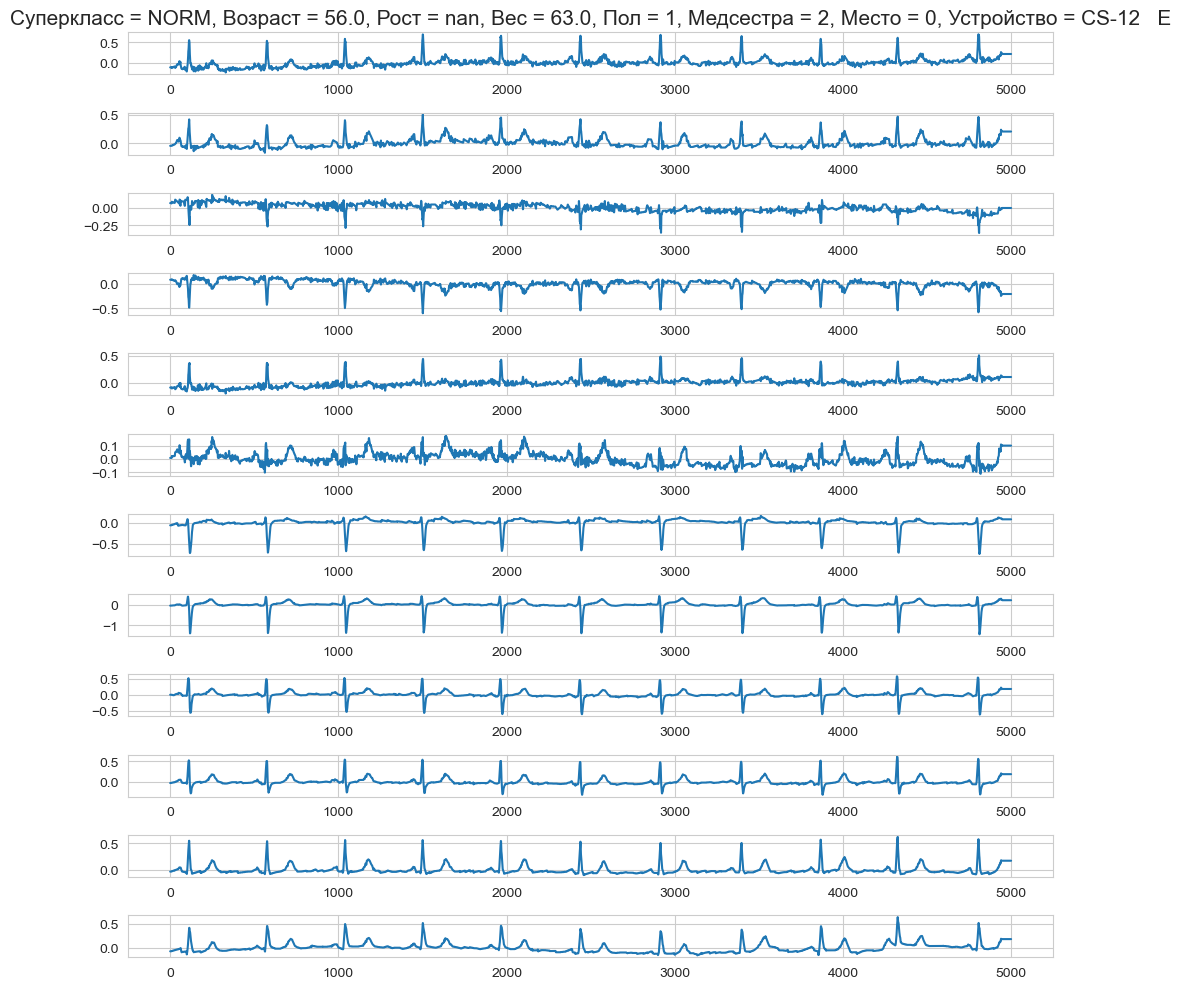

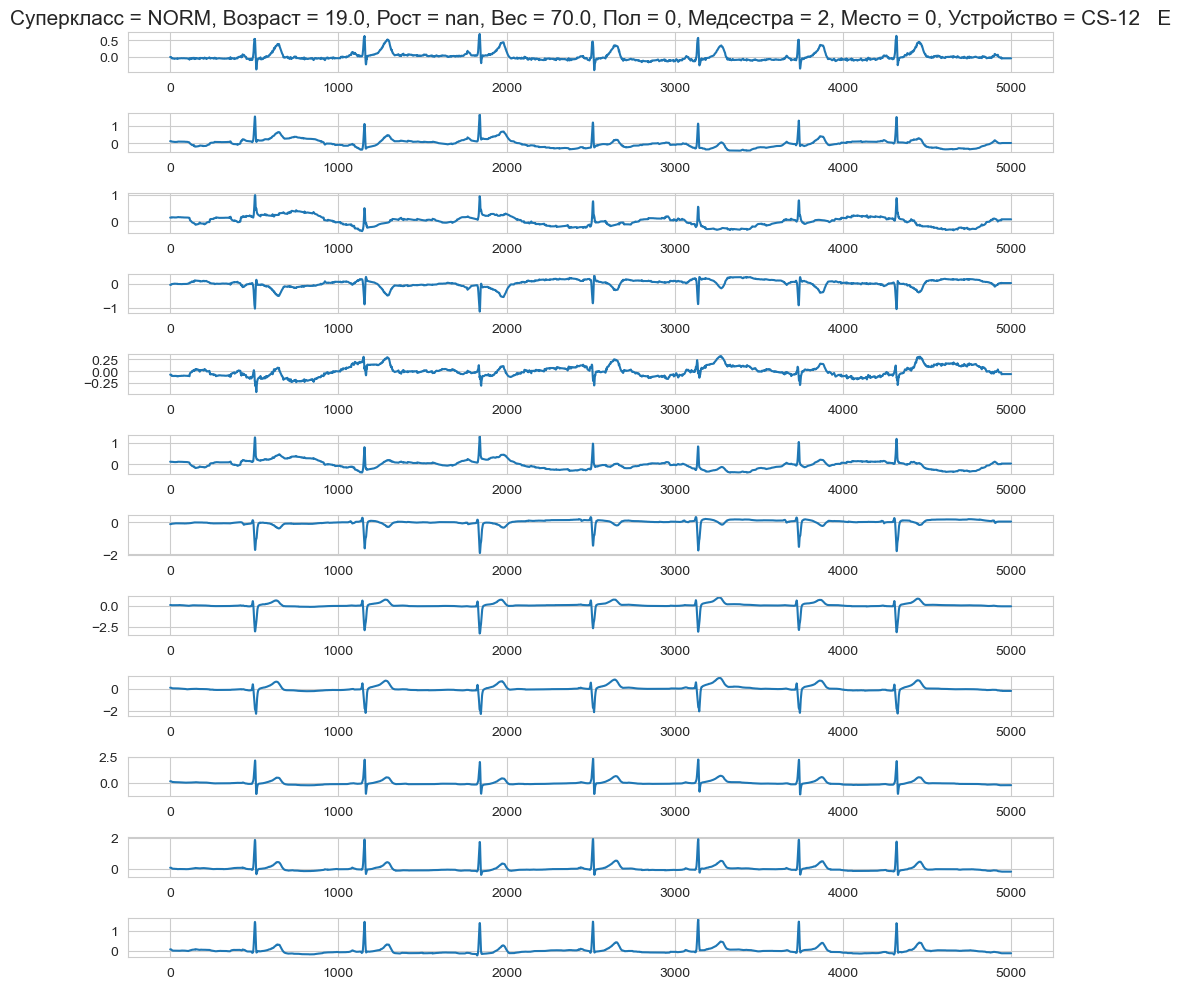

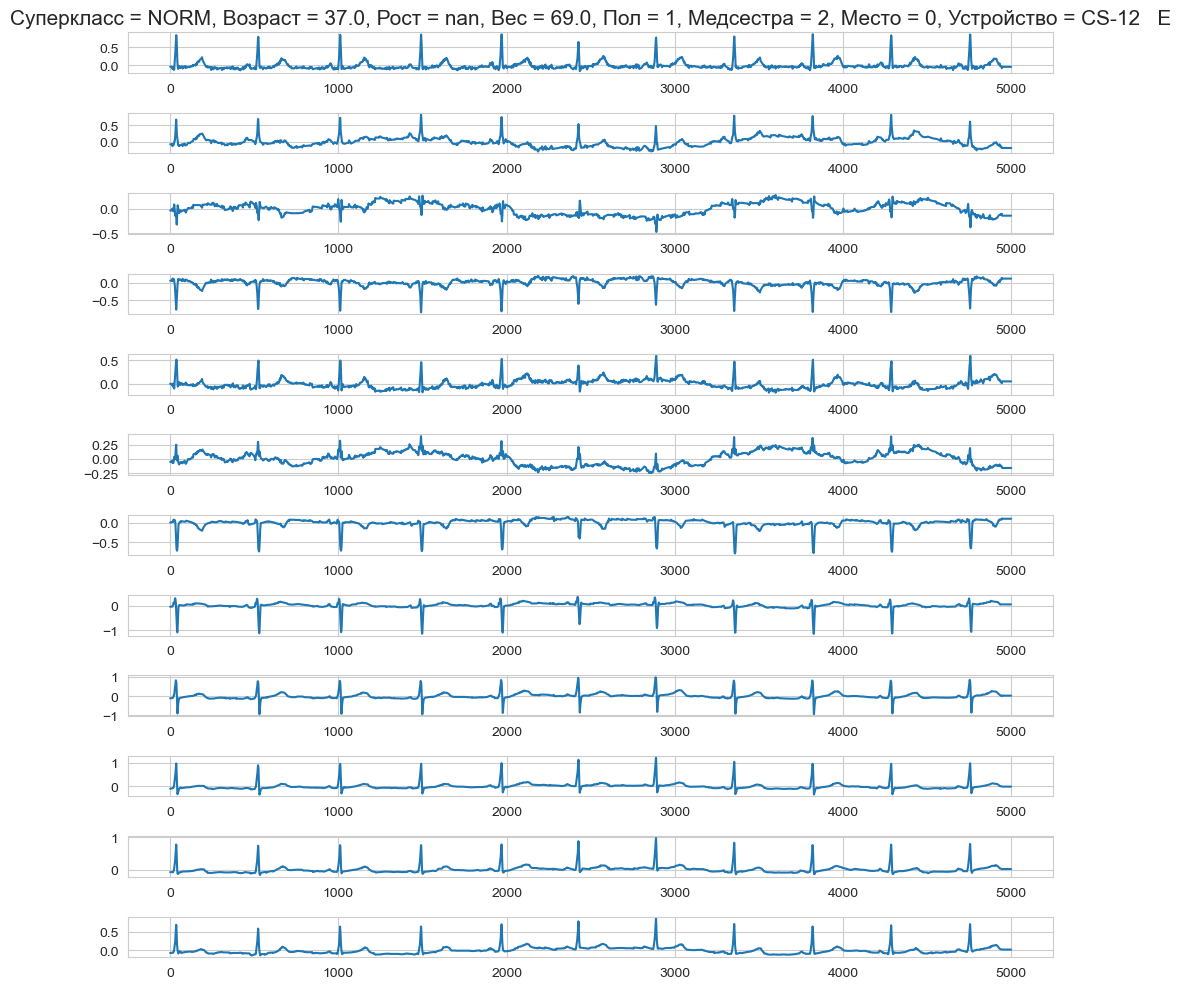

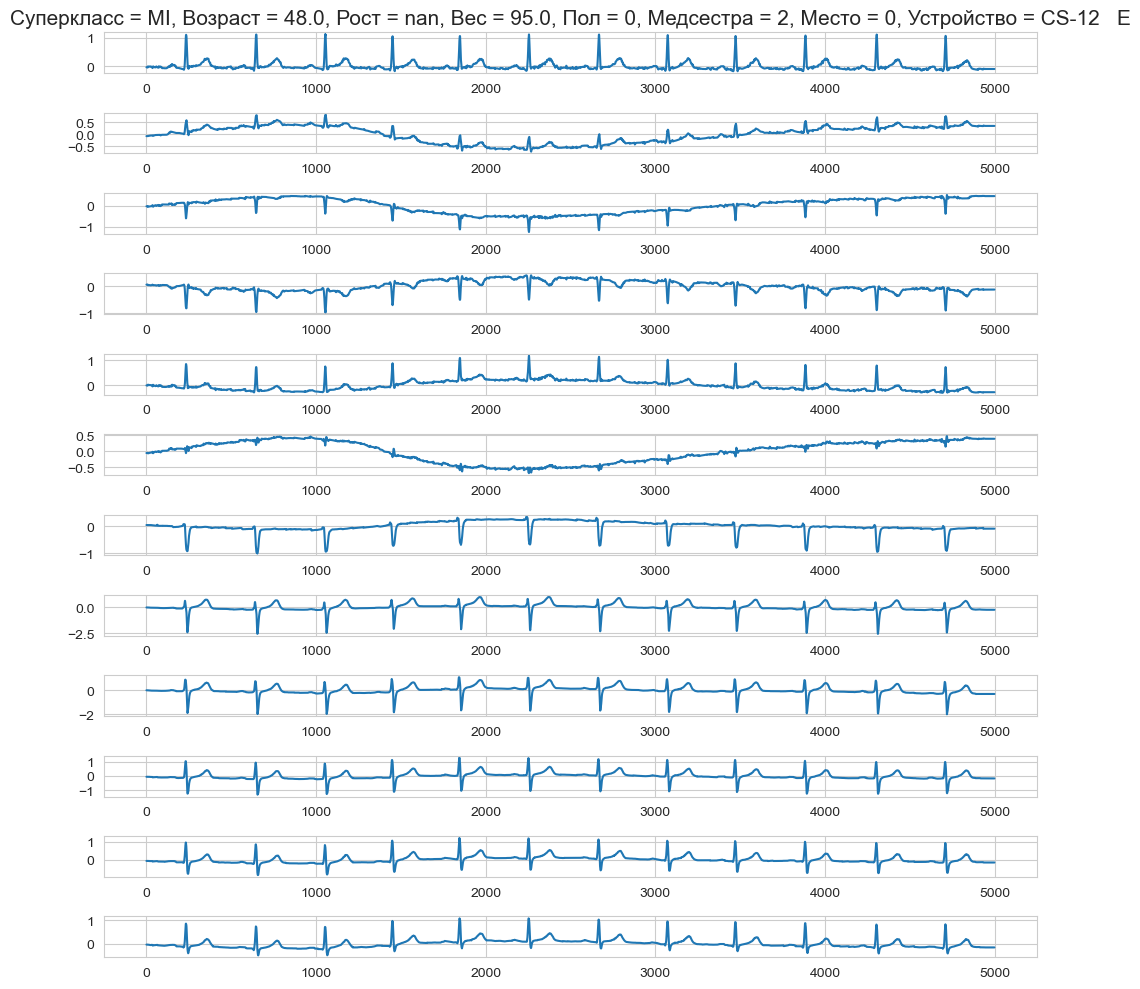

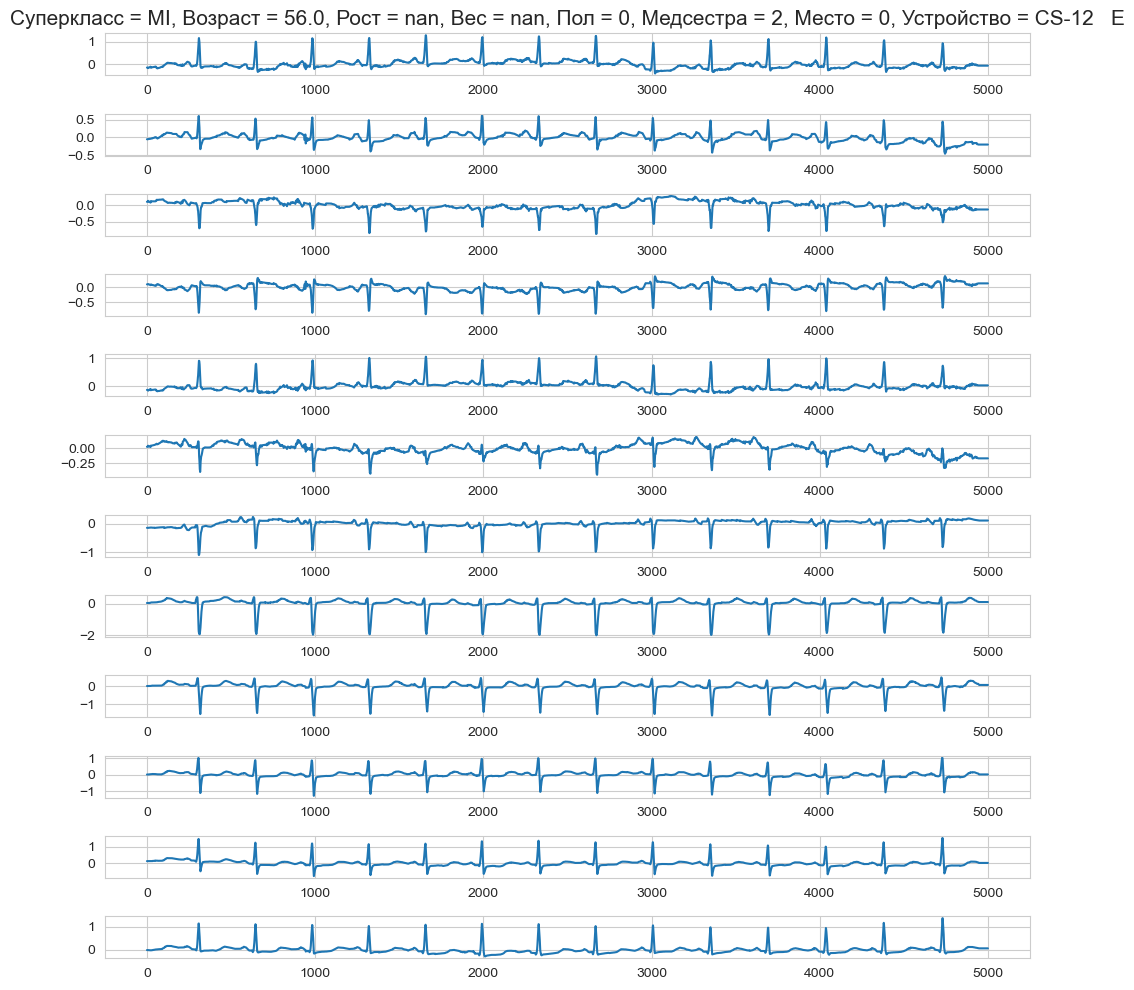

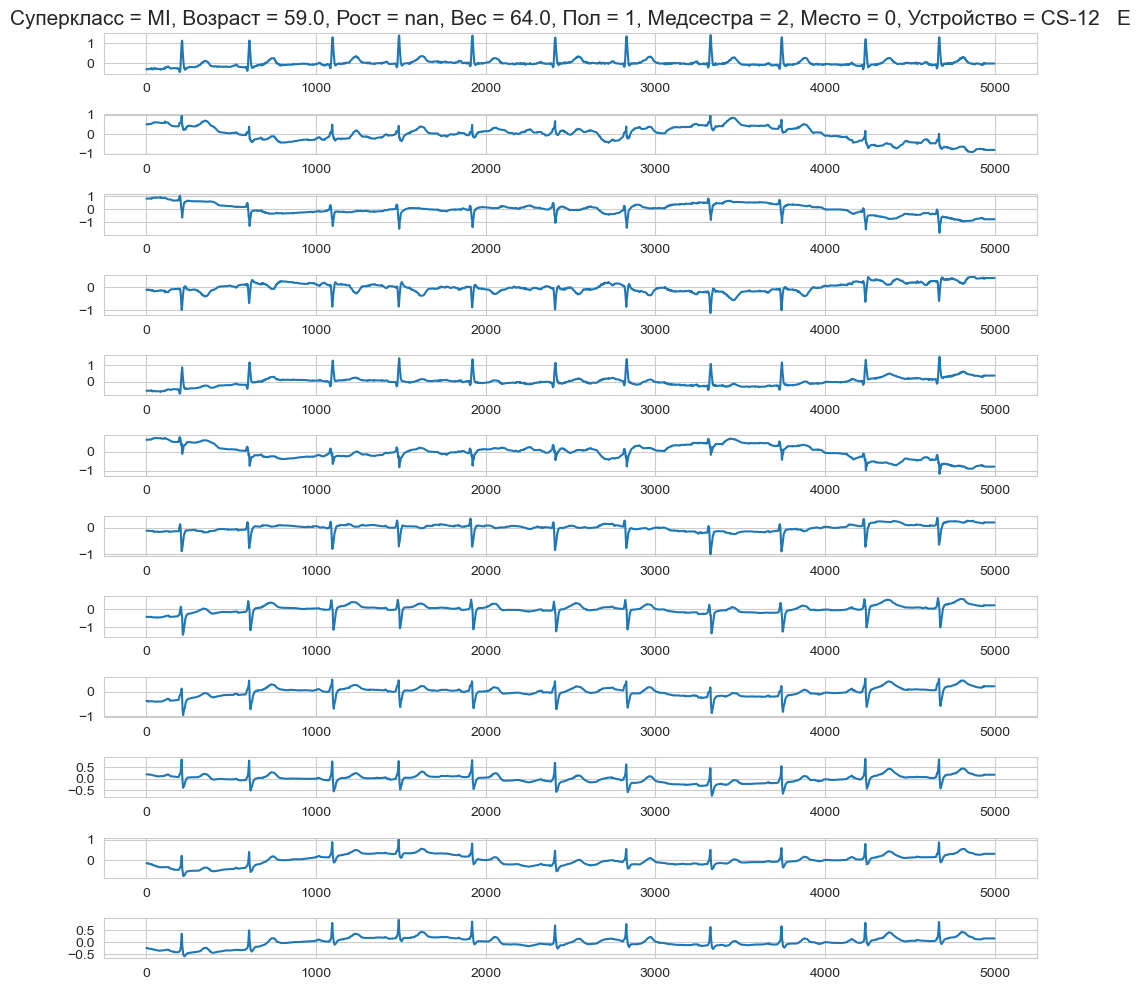

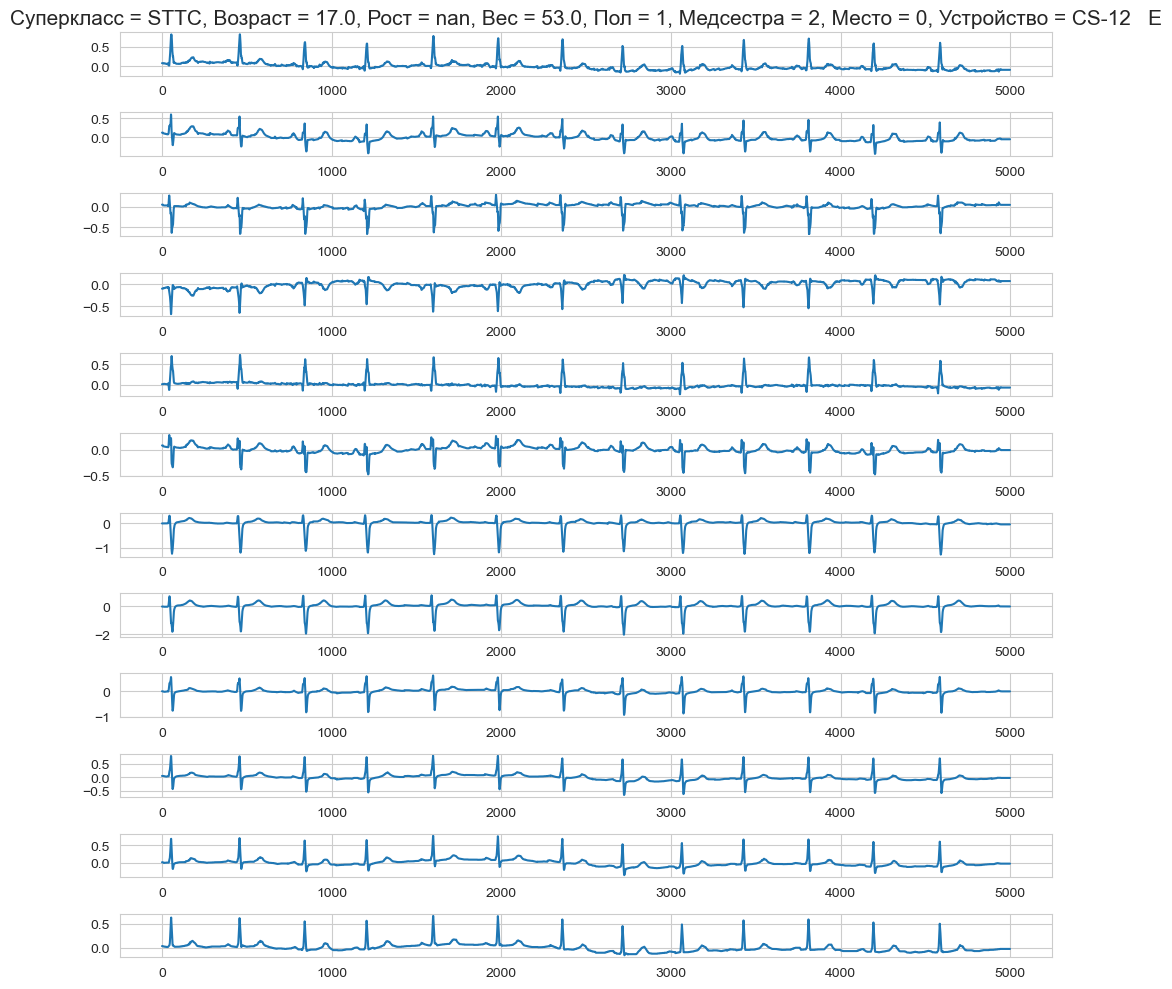

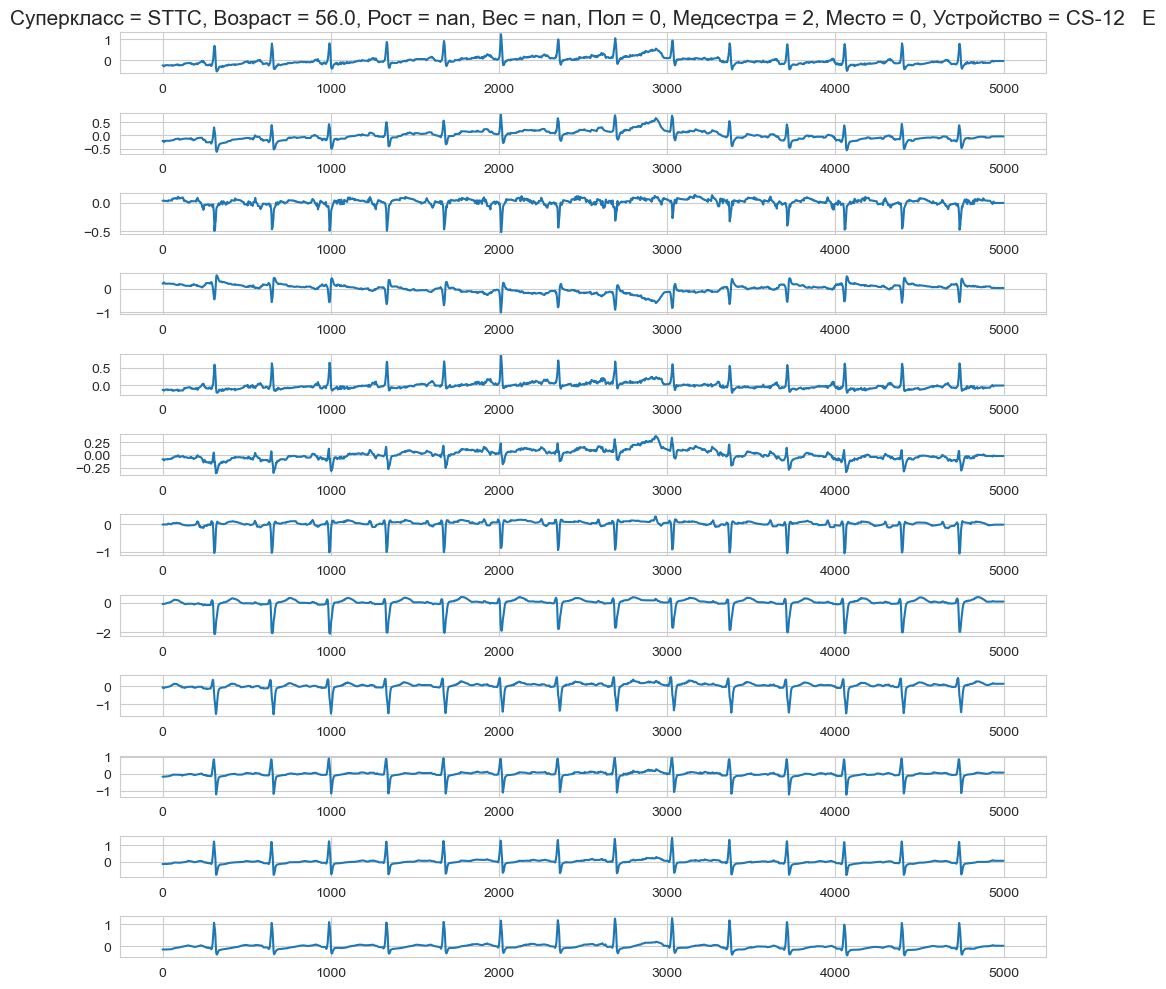

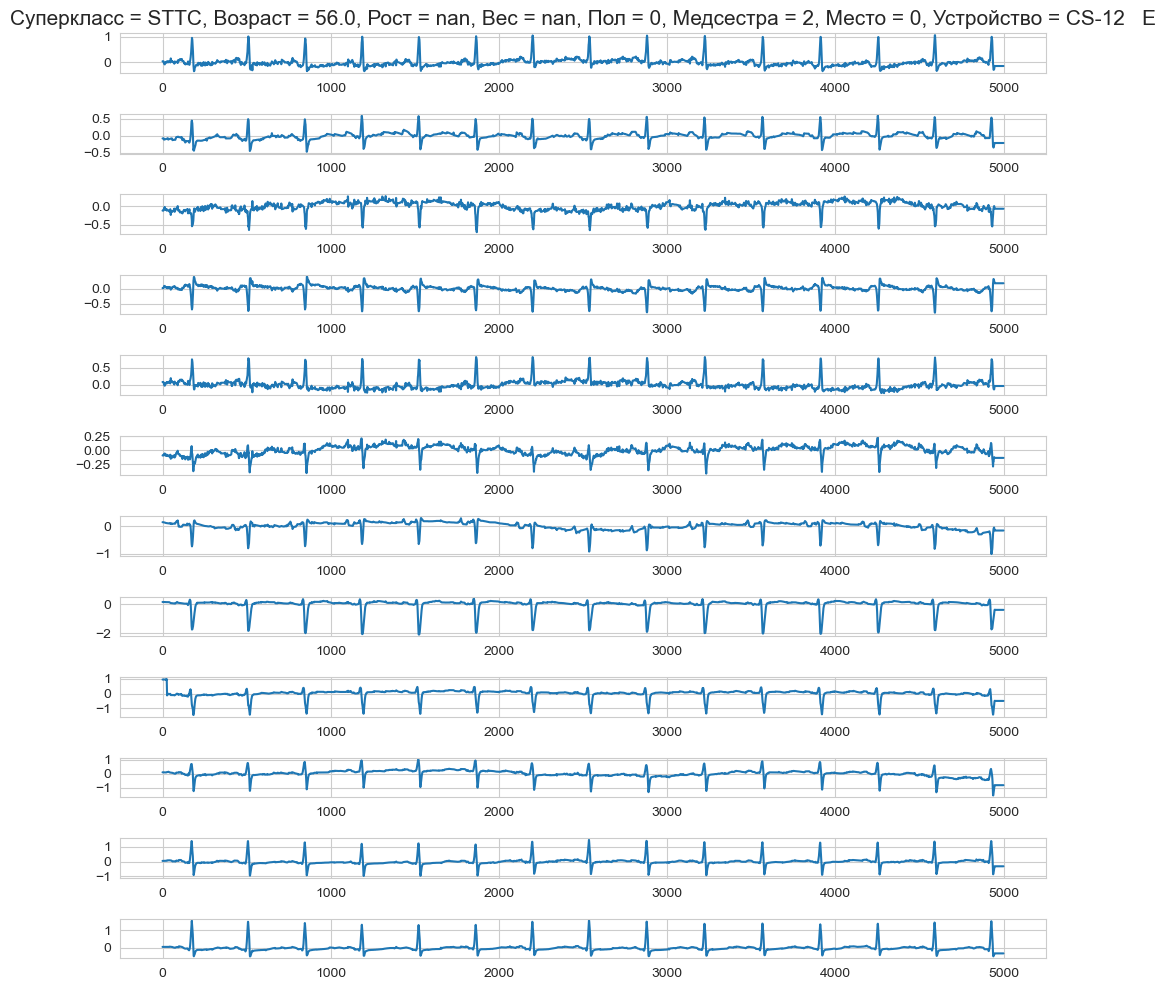

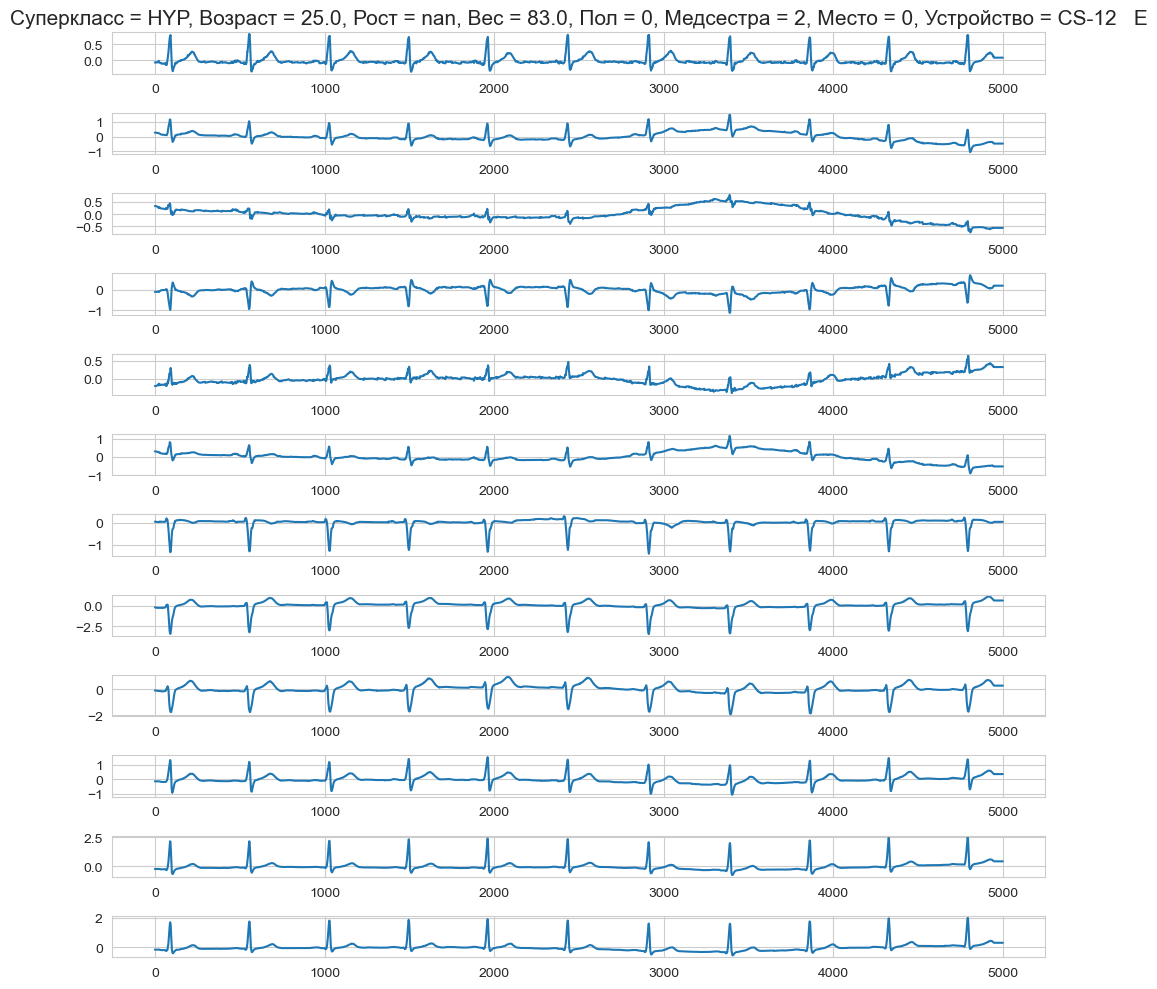

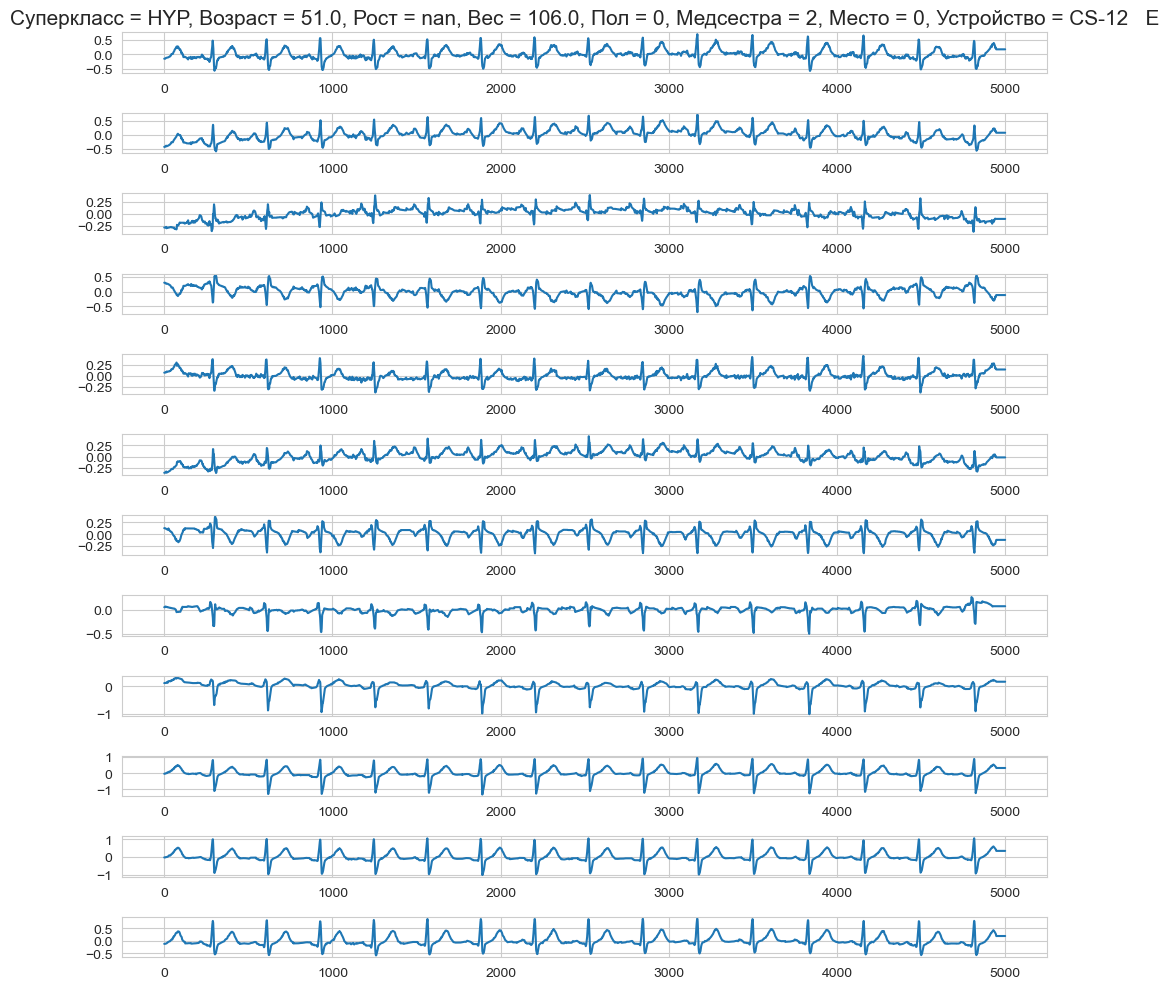

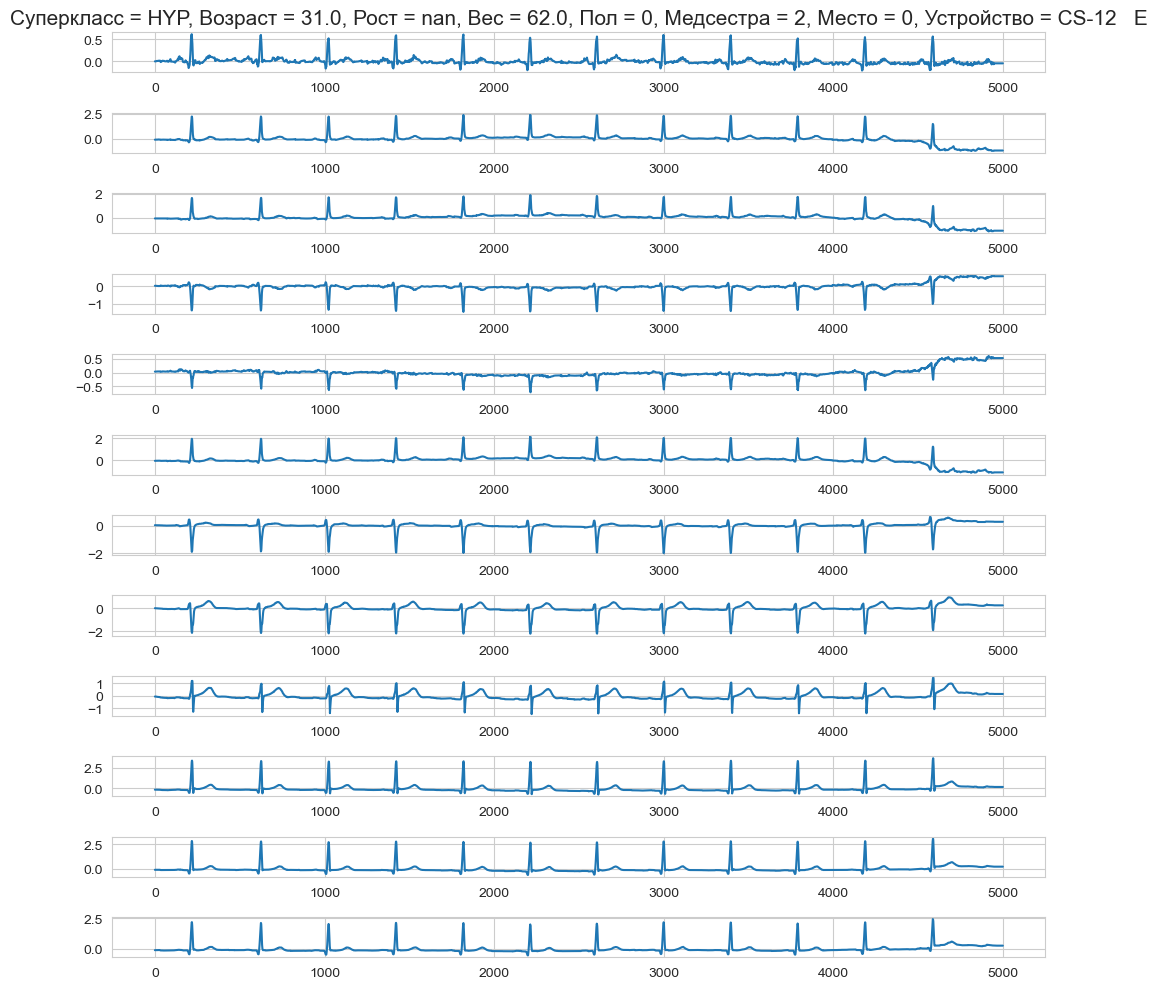

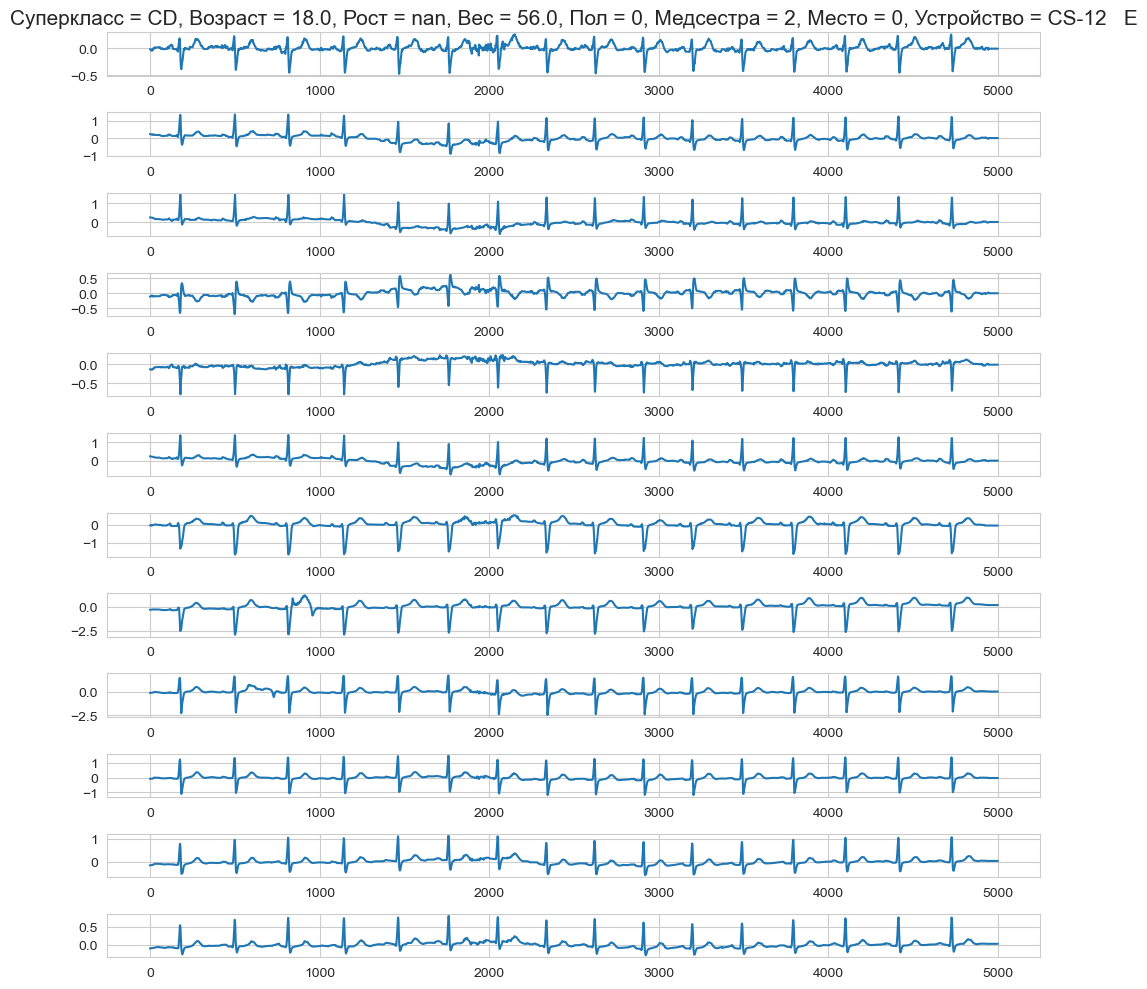

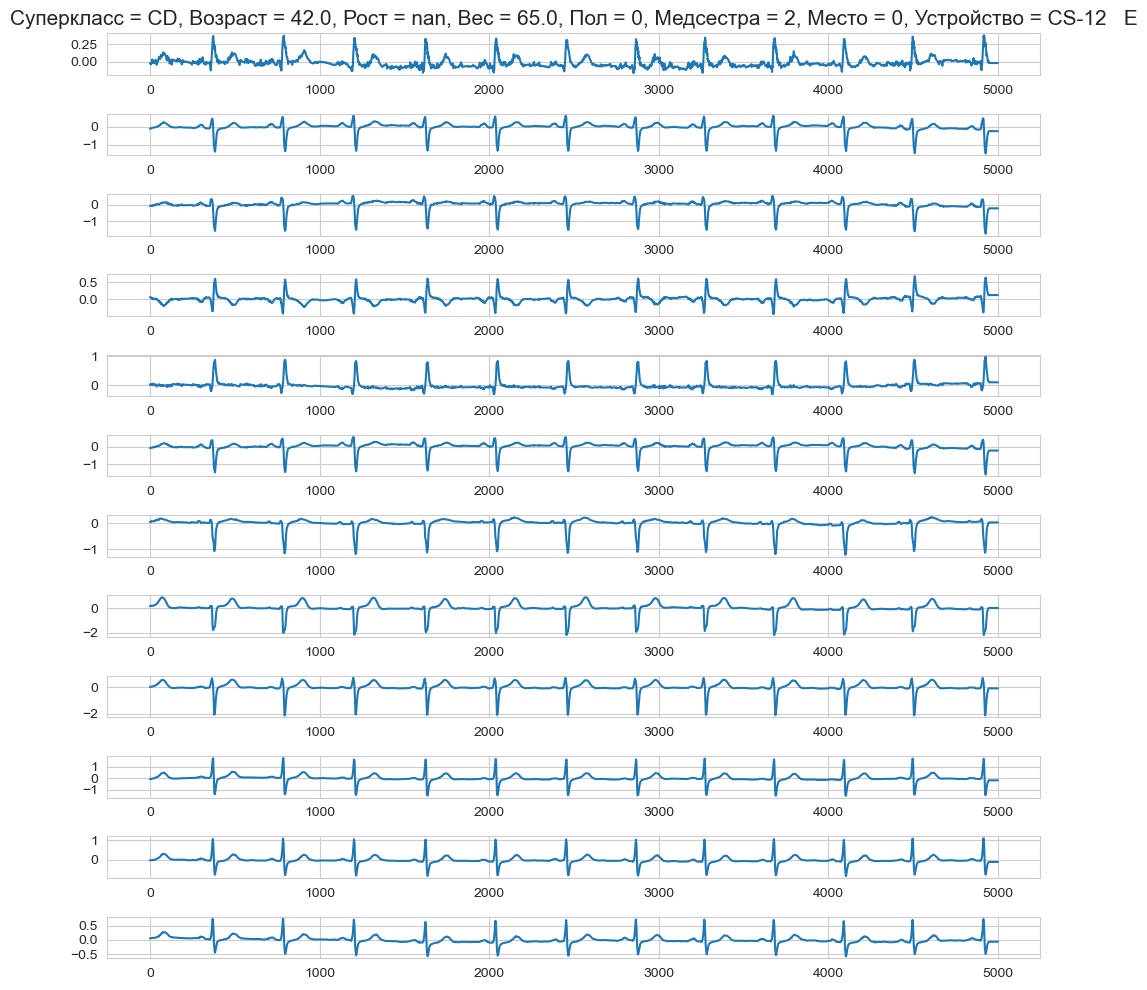

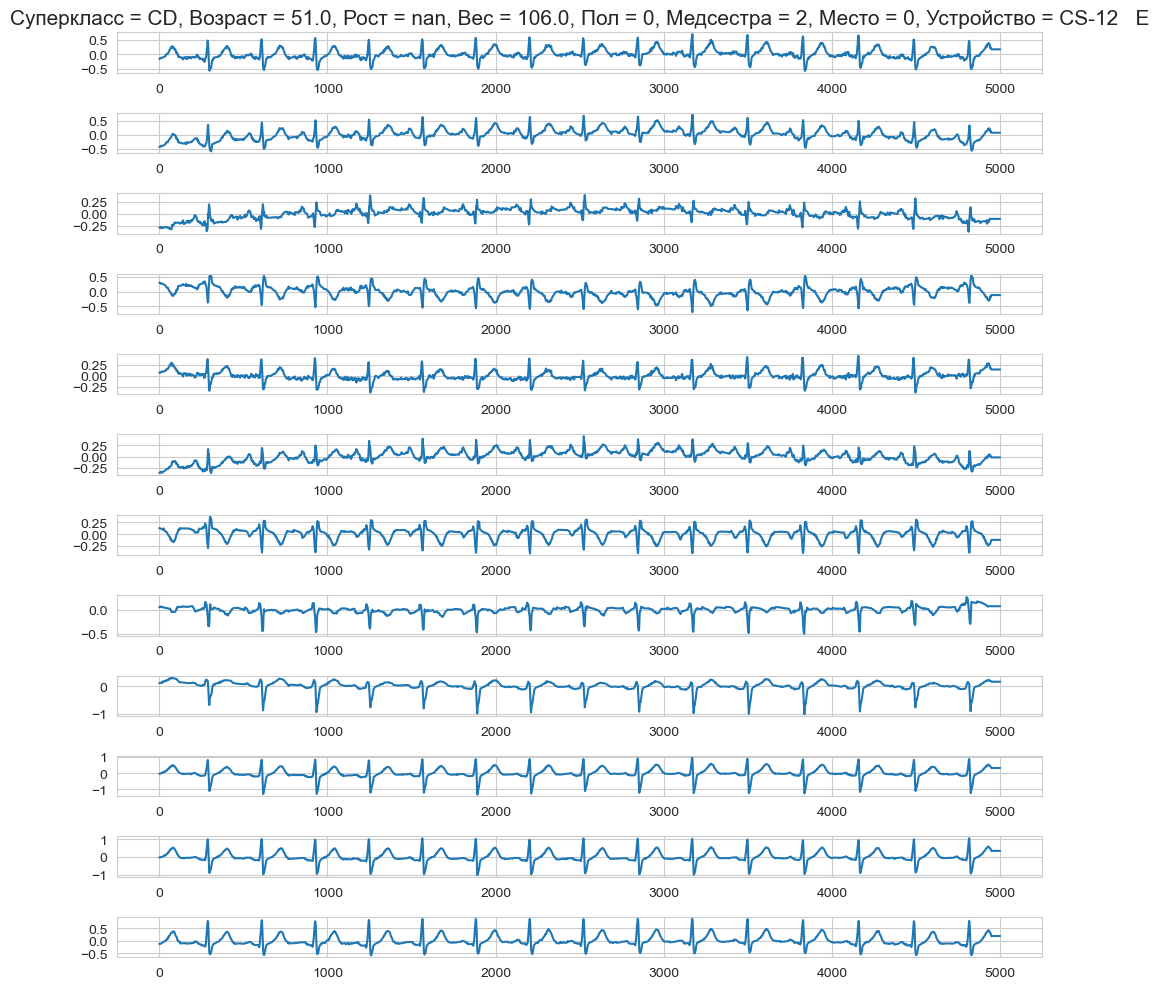

In [196]:
sample_num = 3

for superclass in superclass_cols:
    filt = y_fold[superclass] == 1
    y_selected = y_fold.loc[filt]
    x_selected = x_fold[filt]
    
    for i in range(sample_num):
        y_ = y_selected.iloc[i]
        x_ = x_selected[i]

        bar, axes = plt.subplots(x_.shape[1], 1, figsize=(10,10))
        title = "Суперкласс = {}, Возраст = {}, Рост = {}, Вес = {}, Пол = {}, Медсестра = {}, Место = {}, Устройство = {}".format(superclass, 
                                                                                                                           y_['age'], y_['height'], y_['weight'],
                                                                                                                           y_['sex'], y_['nurse'], y_['site'], y_['device'],)
        axes[0].set_title(title, fontsize=15)        
        for c in np.arange(x_.shape[1]):
            sns.lineplot(x=np.arange(x_.shape[0]), y=x_[:, c], ax=axes[c])        
        plt.tight_layout()
        plt.show()

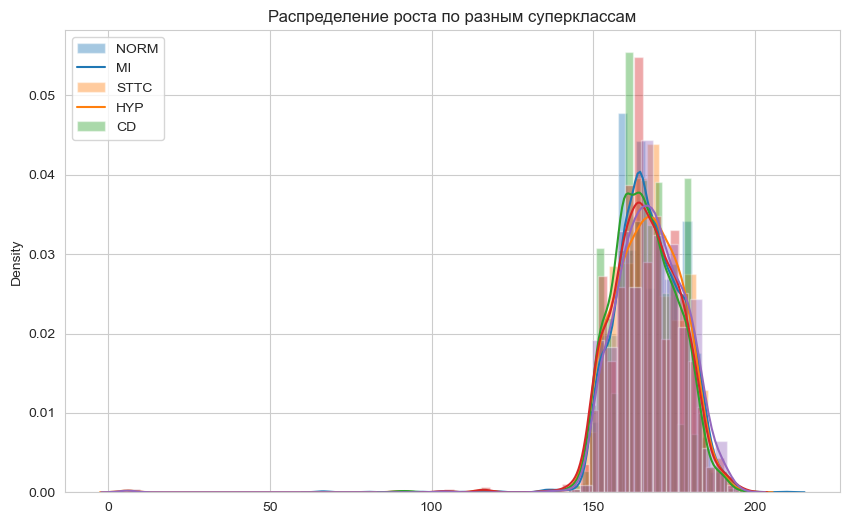

In [197]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Распределение роста по разным суперклассам')
for superclass in superclass_cols:
    data = y_fold.loc[y_fold[superclass] == 1][['height']]
    sns.distplot(data, label=superclass)

plt.legend(labels=superclass_cols, loc='upper left')
plt.show()

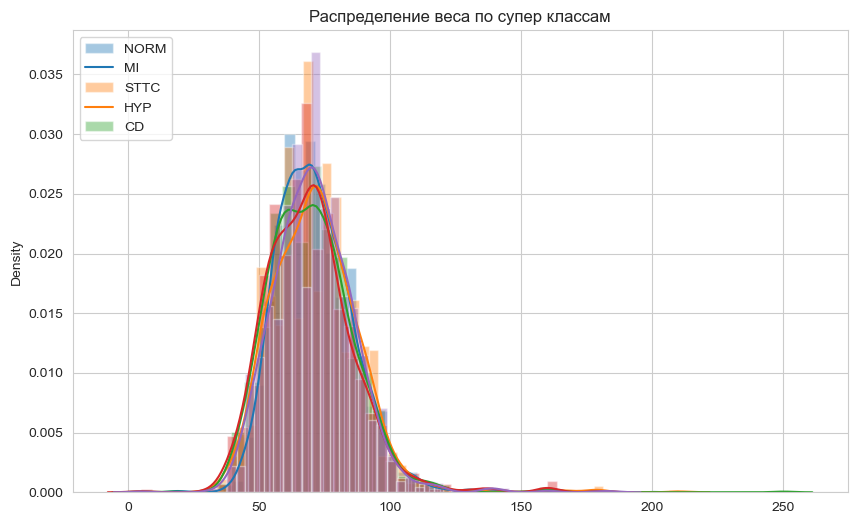

In [198]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Распределение веса по супер классам')
for superclass in superclass_cols:
    data = y_fold.loc[y_fold[superclass] == 1][['weight']]
    sns.distplot(data, label=superclass)

plt.legend(labels=superclass_cols, loc='upper left')
plt.show()

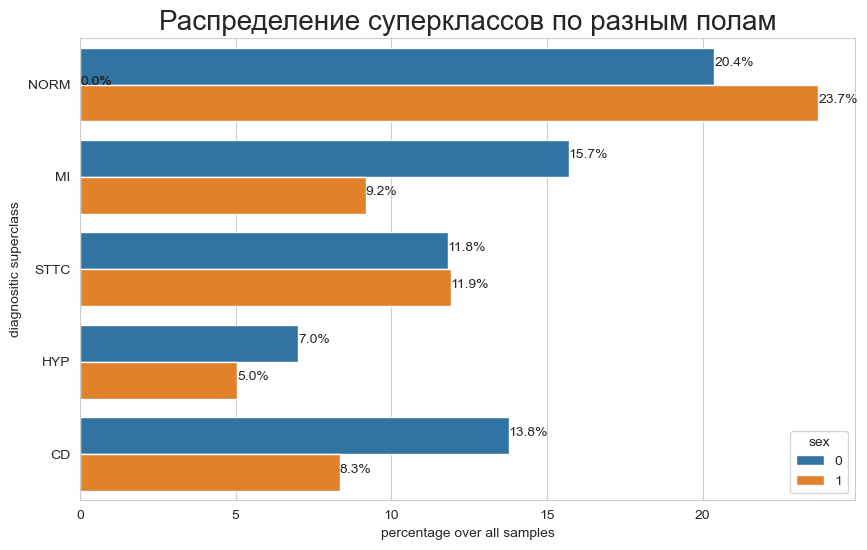

In [199]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
    
ax.set_title("Распределение суперклассов по разным полам", fontsize=20)

all_index, all_count, all_values = [], [], []
for sex in y_fold.sex.unique():
    vc = y_fold.loc[y_fold.sex == sex][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_fold.shape[0]*100.)
    all_values += [sex]*len(vc)
    #print(all_sex)
    
tmp_df = pd.DataFrame()
tmp_df['diagnositic superclass'] = all_index
tmp_df['percentage over all samples'] = all_count
tmp_df['sex'] = all_values
    
ax = sns.barplot(data=tmp_df, x="percentage over all samples", y="diagnositic superclass", hue="sex", orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width())
plt.show()    

0 - мужчина, 1 - женщина. Видно, что MI присутствует у 15 процентов мужчин, против 9 процентов женщин.

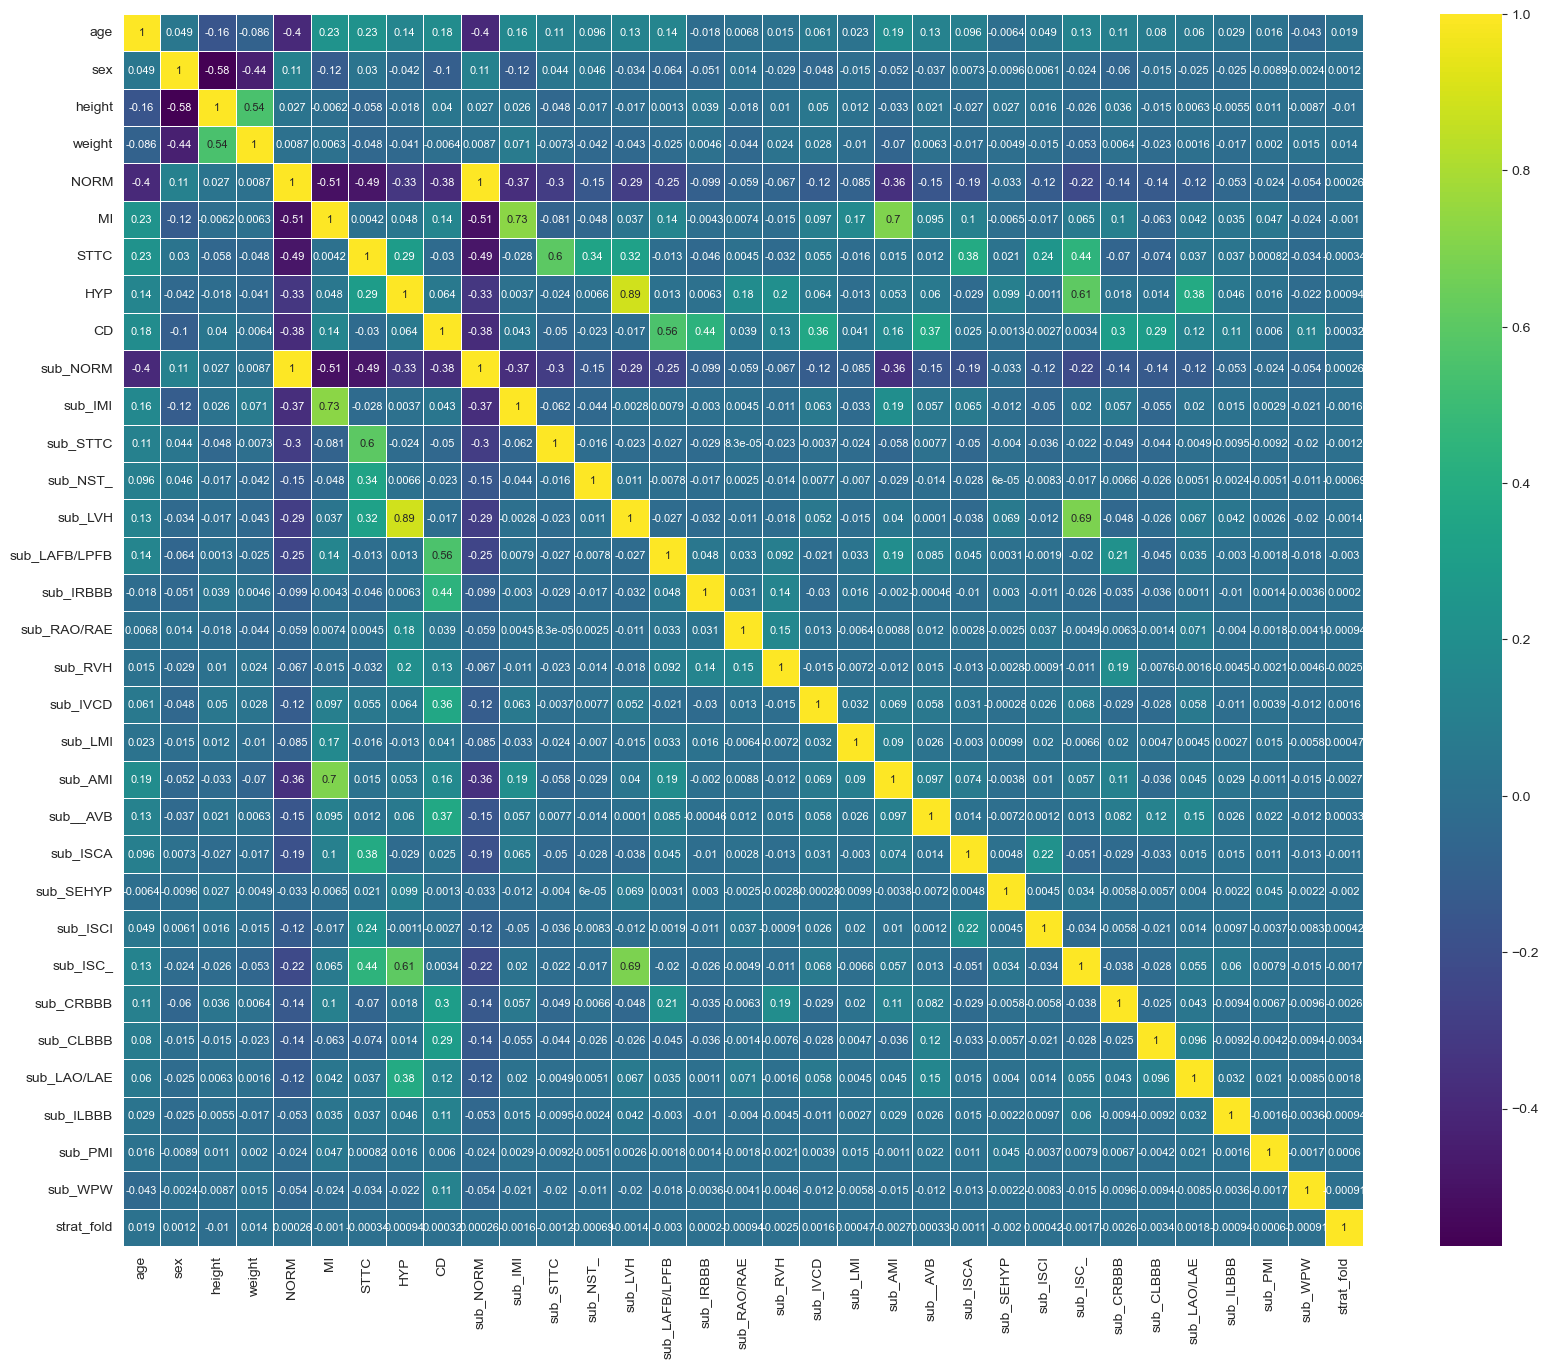

In [204]:
plt.figure(figsize = (20,16))
sns.heatmap(y_fold.corr(numeric_only=True),
            linewidths=0.5, annot=True,cmap='viridis',
            linecolor="white", annot_kws = {'size':8})
plt.show()

In [257]:
corr_matrix = y_fold.corr(numeric_only=True)
corr_unstacked = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack()
sorted_corr_pairs = corr_unstacked.abs().sort_values(ascending=False)
most_correlated_pairs = corr_unstacked[sorted_corr_pairs.index]
most_correlated_pairs.head(20)

NORM     sub_NORM         1.000000
HYP      sub_LVH          0.885565
MI       sub_IMI          0.728989
         sub_AMI          0.697662
sub_LVH  sub_ISC_         0.687792
HYP      sub_ISC_         0.610587
STTC     sub_STTC         0.603370
sex      height          -0.576090
CD       sub_LAFB/LPFB    0.555745
height   weight           0.544532
NORM     MI              -0.510714
MI       sub_NORM        -0.510714
NORM     STTC            -0.487825
STTC     sub_NORM        -0.487825
         sub_ISC_         0.443317
sex      weight          -0.435627
CD       sub_IRBBB        0.435078
age      sub_NORM        -0.396664
         NORM            -0.396664
HYP      sub_LAO/LAE      0.379847
dtype: float64

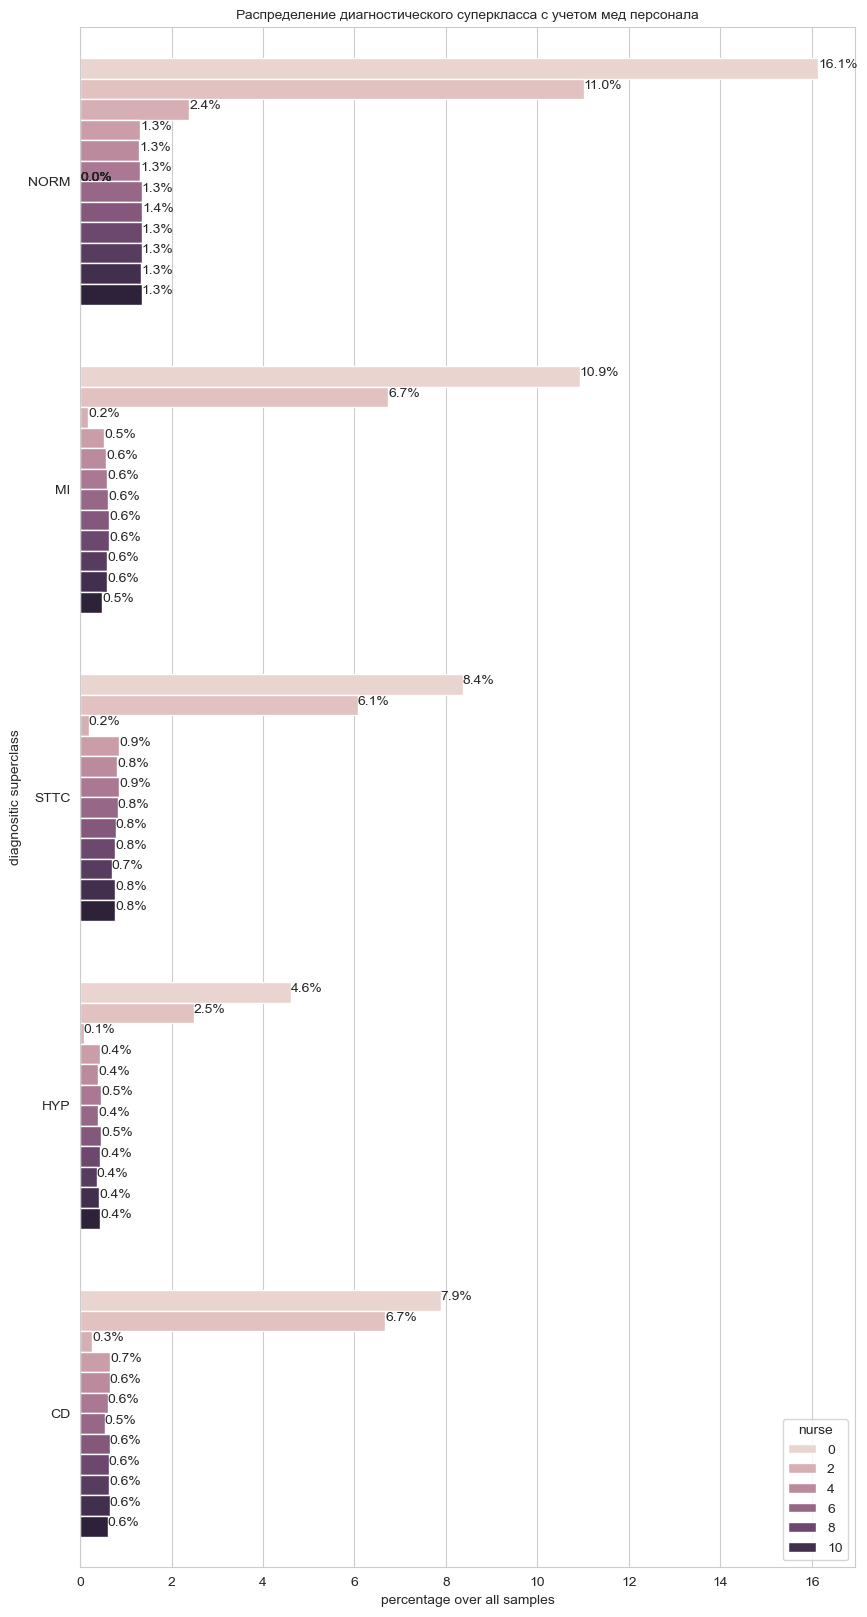

In [226]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,20))
    
ax.set_title("Распределение диагностического суперкласса с учетом мед персонала", fontsize=10)

all_index, all_count, all_values = [], [], []
for nurse in y_fold.nurse.unique():
    vc = y_fold.loc[y_fold.nurse == nurse][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_fold.shape[0]*100.)
    all_values += [nurse]*len(vc)
    #print(all_sex)
    
tmp_df = pd.DataFrame()
tmp_df['diagnositic superclass'] = all_index
tmp_df['percentage over all samples'] = all_count
tmp_df['nurse'] = all_values
    
ax = sns.barplot(data=tmp_df, x="percentage over all samples", y="diagnositic superclass", hue="nurse", orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width())
plt.show()     

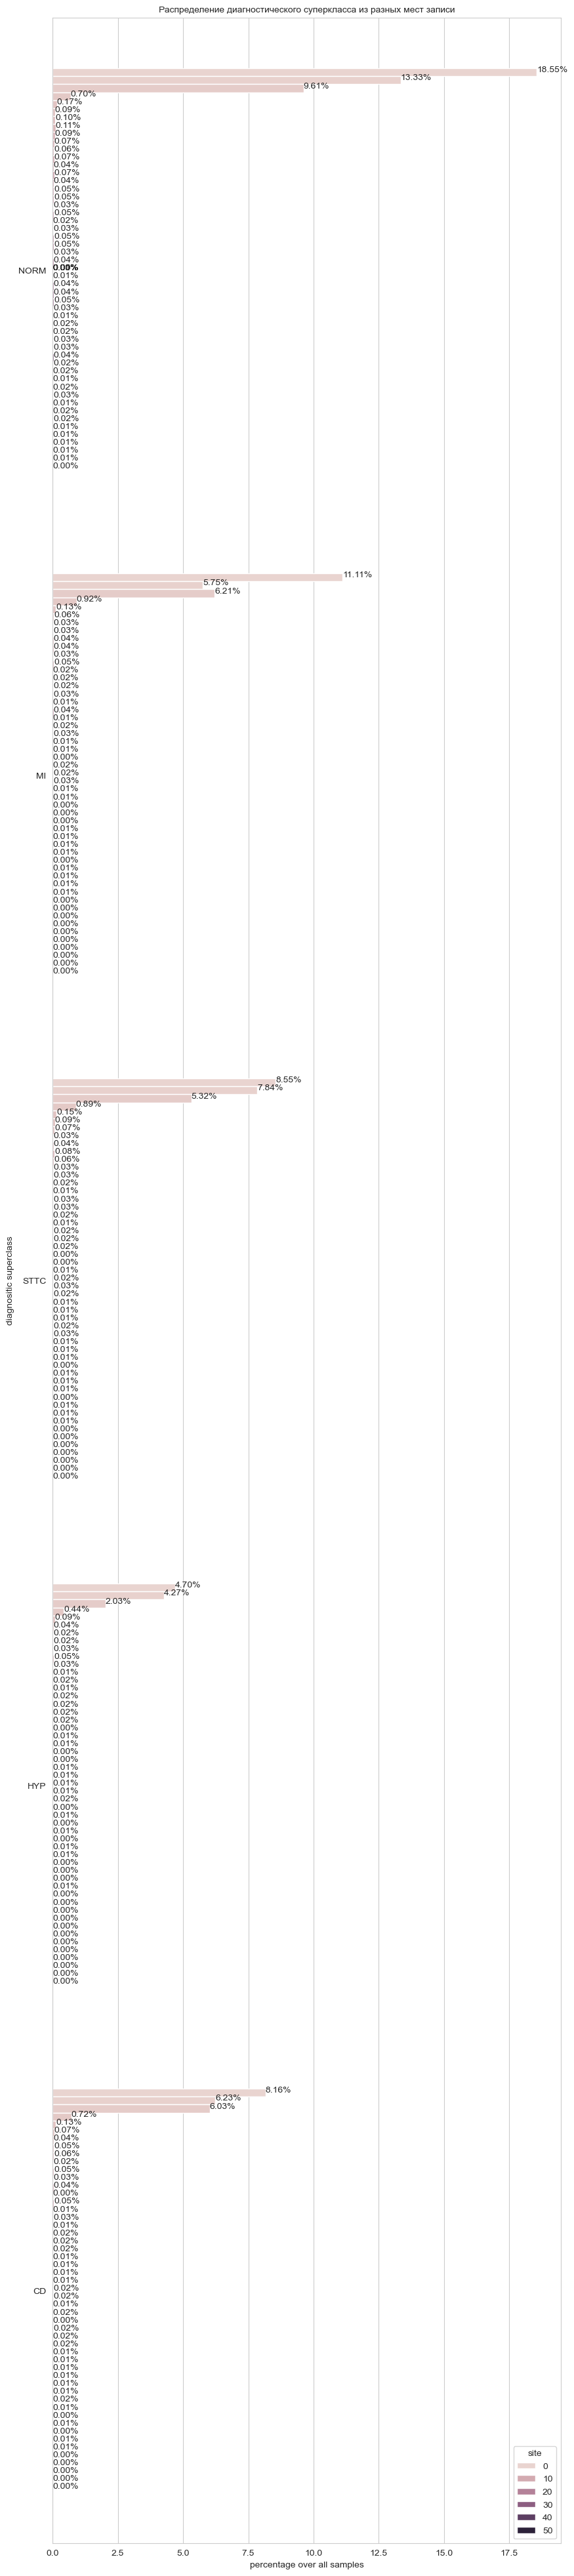

In [228]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,50))    
ax.set_title("Распределение диагностического суперкласса из разных мест записи", fontsize=10)

all_index, all_count, all_values = [], [], []
for site in y_fold.site.unique():
    vc = y_fold.loc[y_fold.site == site][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_fold.shape[0]*100.)
    all_values += [site]*len(vc)
    #print(all_sex)
    
tmp_df = pd.DataFrame()
tmp_df['diagnositic superclass'] = all_index
tmp_df['percentage over all samples'] = all_count
tmp_df['site'] = all_values
    
ax = sns.barplot(data=tmp_df, x="percentage over all samples", y="diagnositic superclass", hue="site", orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.2f%%"% rect.get_width())
plt.show()     

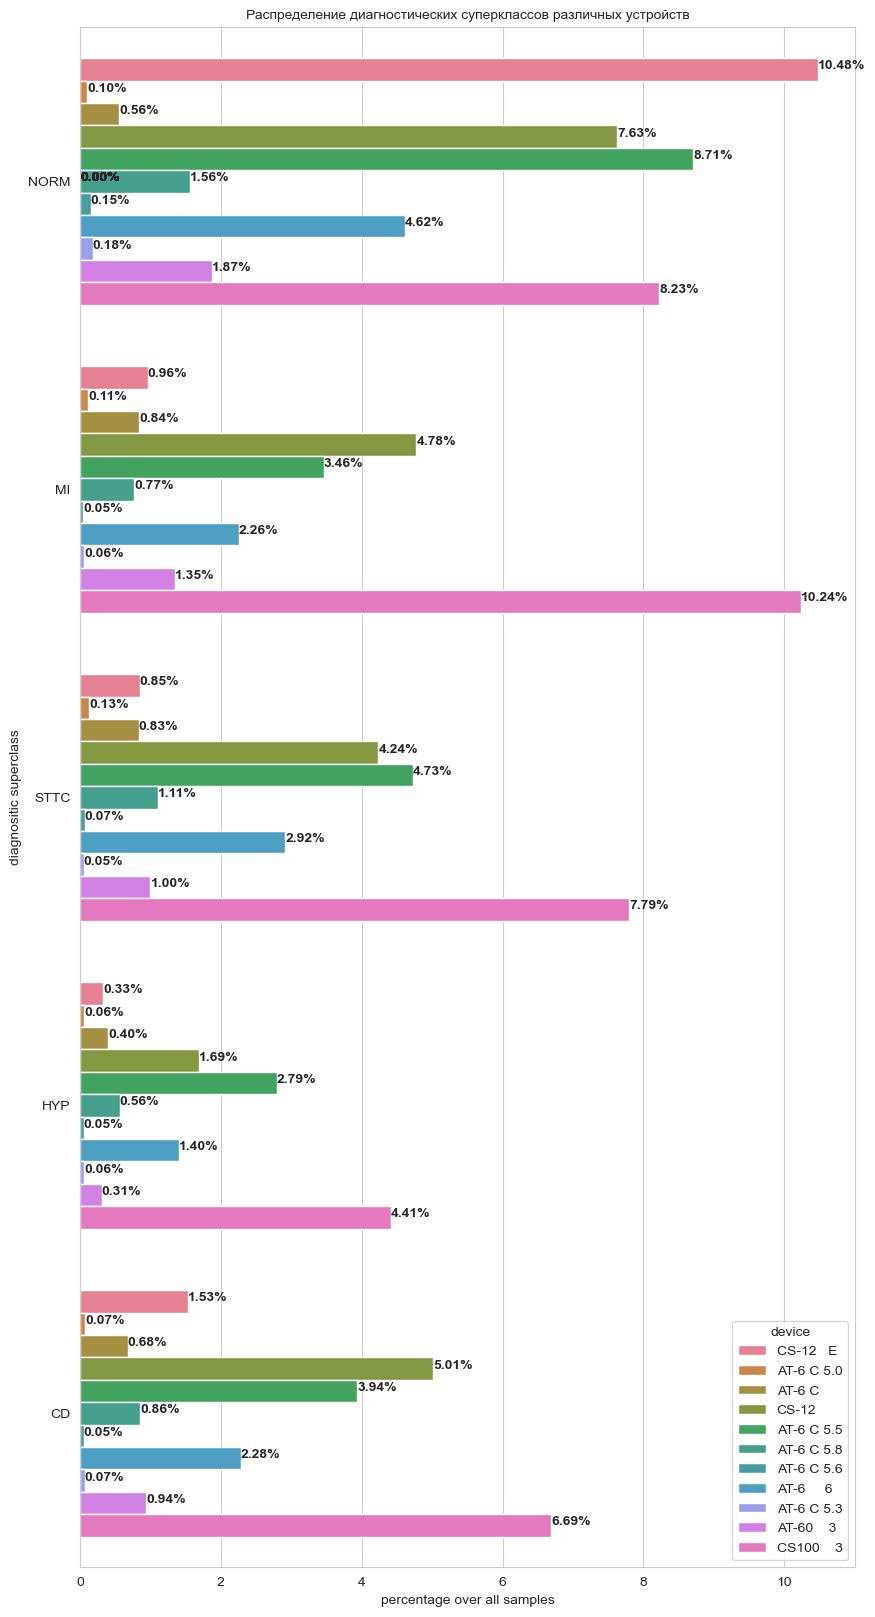

In [230]:

bar,ax = plt.subplots(figsize=(10,20))    
ax.set_title("Распределение диагностических суперклассов различных устройств", fontsize=10)
all_index, all_count, all_values = [], [], []
for device in y_fold.device.unique():
    vc = y_fold.loc[y_fold.device == device][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_fold.shape[0]*100.)
    all_values += [device]*len(vc)
    
tmp_df = pd.DataFrame()
tmp_df['diagnositic superclass'] = all_index
tmp_df['percentage over all samples'] = all_count
tmp_df['device'] = all_values

ax = sns.barplot(data=tmp_df, x="percentage over all samples", y="diagnositic superclass", hue="device", orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.2f%%"% rect.get_width(), weight='bold')
plt.show()    

In [232]:
!pip install missingno

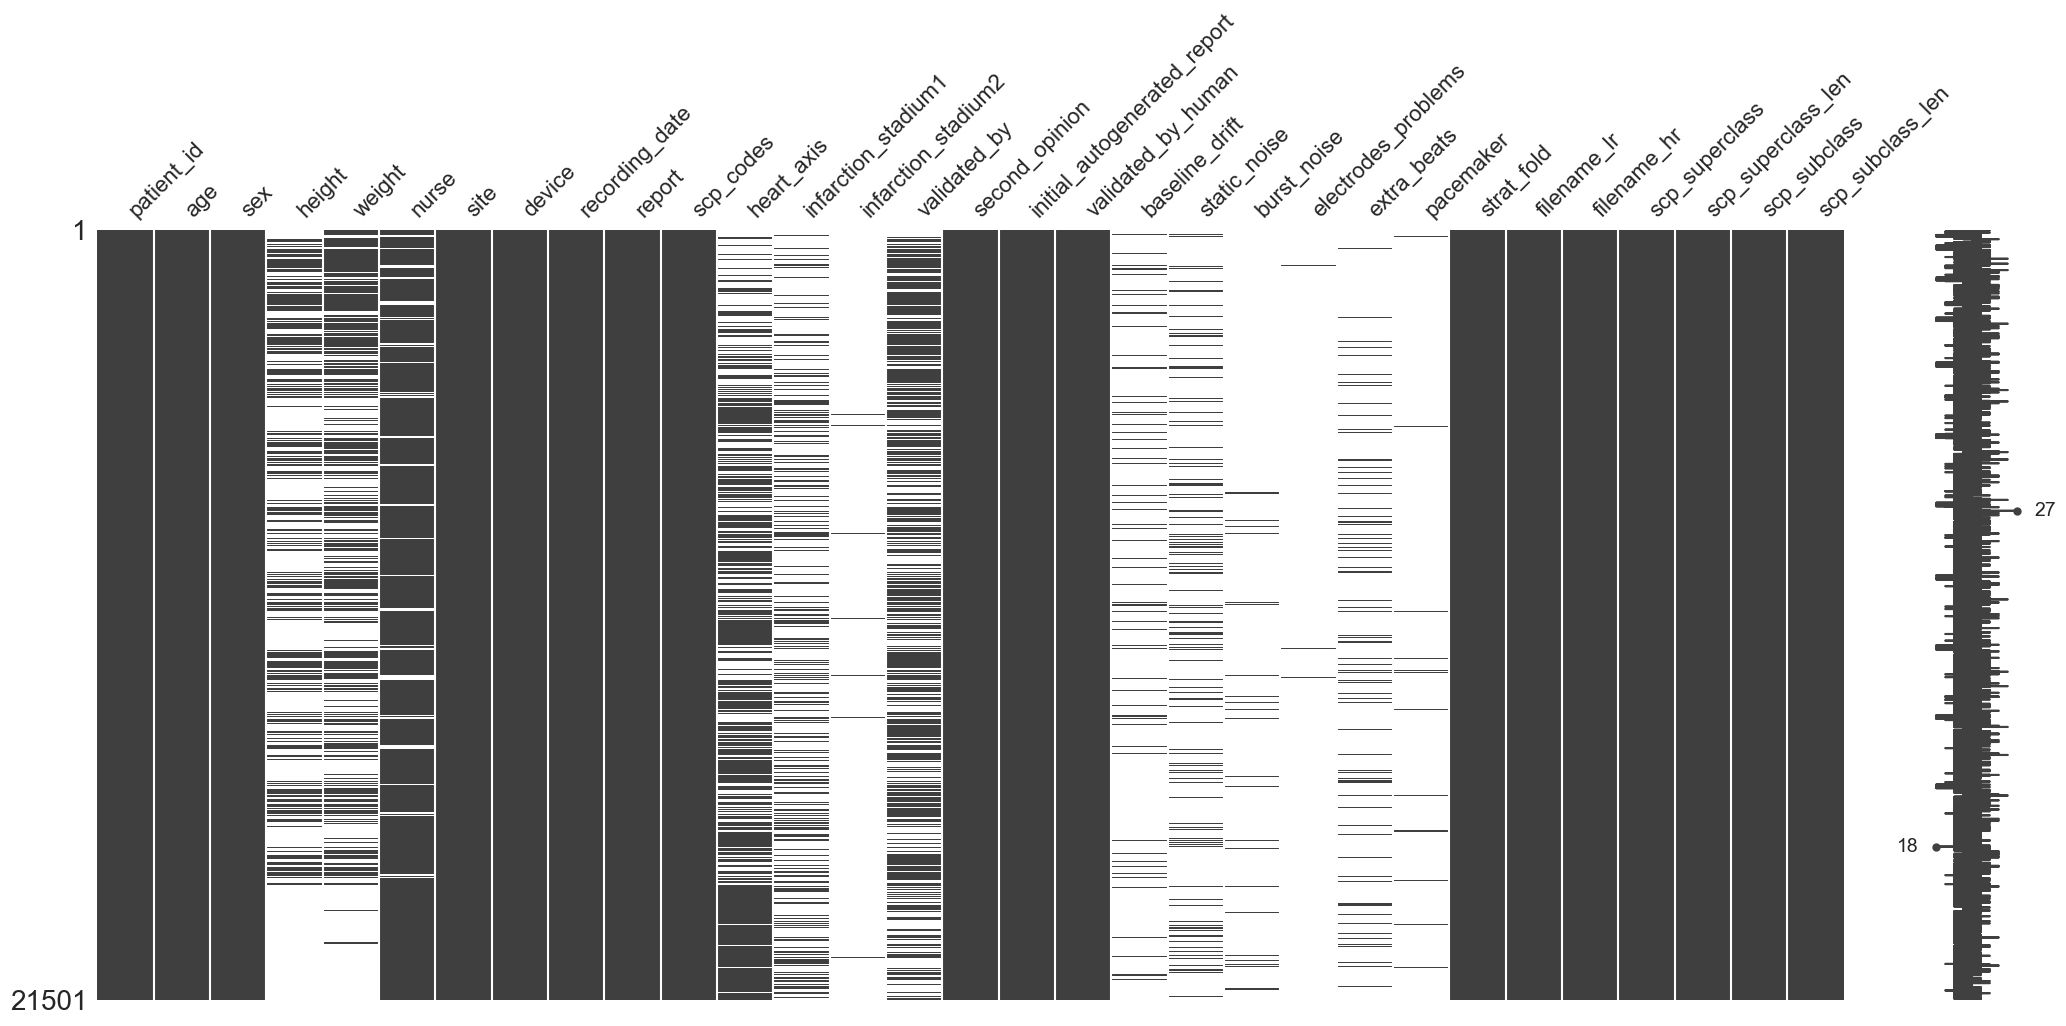

In [234]:
import missingno as msno

msno.matrix(df)
plt.show()

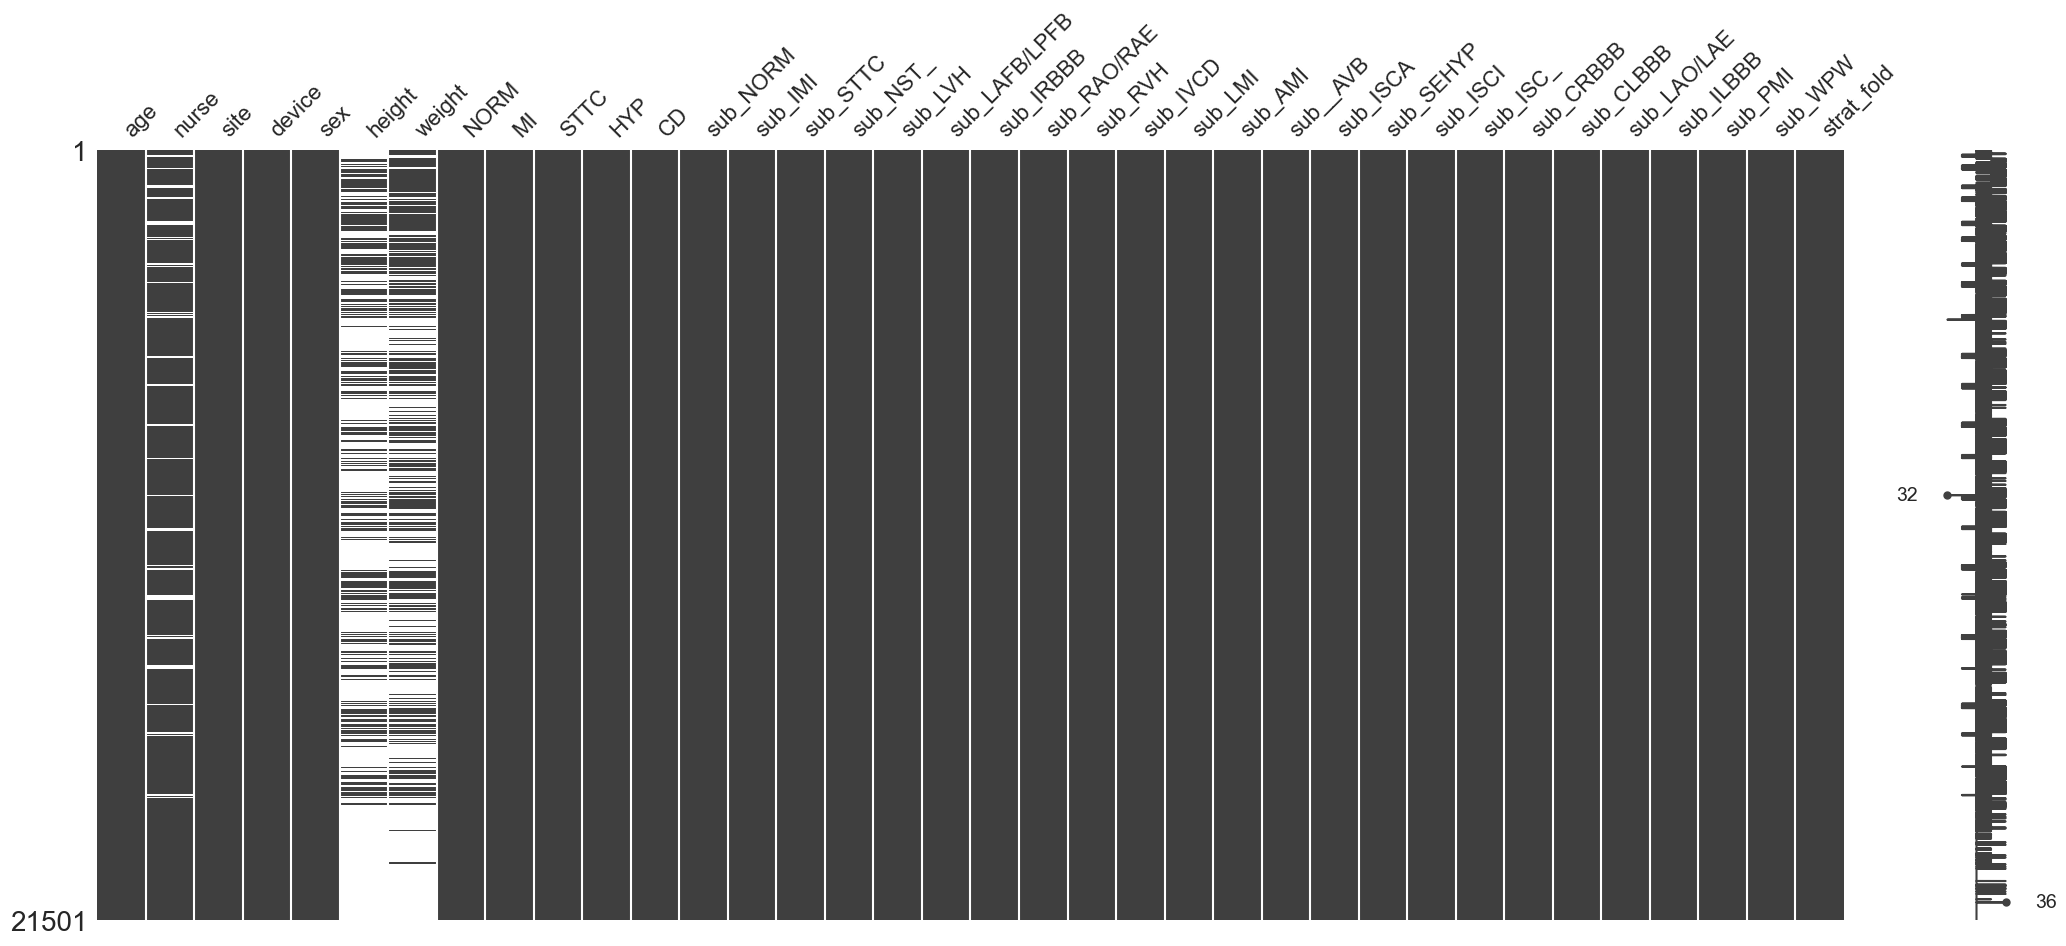

In [236]:
import missingno as msno

msno.matrix(y_fold)
plt.show()

In [238]:
pd.set_option('display.max_columns', None)

In [240]:
df.head(5)

patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1            15709  56.0    1     NaN    63.0      2     0  CS-12   E   
2            13243  19.0    0     NaN    70.0      2     0  CS-12   E   
3            20372  37.0    1     NaN    69.0      2     0  CS-12   E   
4            17014  24.0    0     NaN    82.0      2     0  CS-12   E   
5            17448  19.0    1     NaN    70.0      2     0  CS-12   E   

             recording_date                                  report  \
ecg_id                                                                
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg   
5       1984-11-17 10:43:15              sinusrhythmus normales ekg   

                                       scp_codes heart_axis  \
ecg_id                                                        
1       {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}        NaN   
2                   {'NORM': 80.0, 'SBRAD': 0.0}        NaN   
3                     {'NORM': 100.0, 'SR': 0.0}        NaN   
4                     {'NORM': 100.0, 'SR': 0.0}        NaN   
5                     {'NORM': 100.0, 'SR': 0.0}        NaN   

       infarction_stadium1 infarction_stadium2  validated_by  second_opinion  \
ecg_id                                                                         
1                      NaN                 NaN          <NA>           False   
2                      NaN                 NaN          <NA>           False   
3                      NaN                 NaN          <NA>           False   
4                      NaN                 NaN          <NA>           False   
5                      NaN                 NaN          <NA>           False   

        initial_autogenerated_report  validated_by_human  baseline_drift  \
ecg_id                                                                     
1                              False                True             NaN   
2                              False                True             NaN   
3                              False                True             NaN   
4                              False                True    , II,III,AVF   
5                              False                True   , III,AVR,AVF   

       static_noise burst_noise electrodes_problems extra_beats pacemaker  \
ecg_id                                                                      
1         , I-V1,           NaN                 NaN         NaN       NaN   
2               NaN         NaN                 NaN         NaN       NaN   
3               NaN         NaN                 NaN         NaN       NaN   
4               NaN         NaN                 NaN         NaN       NaN   
5               NaN         NaN                 NaN         NaN       NaN   

        strat_fold                filename_lr                filename_hr  \
ecg_id                                                                     
1                3  records100/00000/00001_lr  records500/00000/00001_hr   
2                2  records100/00000/00002_lr  records500/00000/00002_hr   
3                5  records100/00000/00003_lr  records500/00000/00003_hr   
4                3  records100/00000/00004_lr  records500/00000/00004_hr   
5                4  records100/00000/00005_lr  records500/00000/00005_hr   

       scp_superclass  scp_superclass_len scp_subclass  scp_subclass_len  
ecg_id                                                                    
1              [NORM]                   1   [sub_NORM]                 1  
2              [NORM]                   1   [sub_NORM]                 1  
3              [NORM]                   1   [sub_NORM]                 1  
4             

In [242]:
df[[col for col in df.columns if col not in ('scp_superclass','scp_codes', 'scp_subclass')]].nunique(dropna=True)

patient_id                      18607
age                                85
sex                                 2
height                             74
weight                            124
nurse                              12
site                               51
device                             11
recording_date                  21497
report                           9670
heart_axis                          8
infarction_stadium1                 6
infarction_stadium2                 3
validated_by                       12
second_opinion                      2
initial_autogenerated_report        2
validated_by_human                  2
baseline_drift                    312
static_noise                      122
burst_noise                       102
electrodes_problems                14
extra_beats                       128
pacemaker                           4
strat_fold                         10
filename_lr                     21501
filename_hr                     21501
scp_supercla

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21501 entries, 1 to 21837
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21501 non-null  int64  
 1   age                           21501 non-null  float64
 2   sex                           21501 non-null  int64  
 3   height                        6812 non-null   float64
 4   weight                        9263 non-null   float64
 5   nurse                         20056 non-null  Int64  
 6   site                          21486 non-null  Int64  
 7   device                        21501 non-null  object 
 8   recording_date                21501 non-null  object 
 9   report                        21501 non-null  object 
 10  scp_codes                     21501 non-null  object 
 11  heart_axis                    13167 non-null  object 
 12  infarction_stadium1           5489 non-null   object 
 13  infarc

In [252]:
y_fold.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21501 entries, 1 to 21837
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            21501 non-null  float64
 1   nurse          20056 non-null  object 
 2   site           21486 non-null  object 
 3   device         21501 non-null  object 
 4   sex            21501 non-null  int64  
 5   height         6812 non-null   float64
 6   weight         9263 non-null   float64
 7   NORM           21501 non-null  int64  
 8   MI             21501 non-null  int64  
 9   STTC           21501 non-null  int64  
 10  HYP            21501 non-null  int64  
 11  CD             21501 non-null  int64  
 12  sub_NORM       21501 non-null  int64  
 13  sub_IMI        21501 non-null  int64  
 14  sub_STTC       21501 non-null  int64  
 15  sub_NST_       21501 non-null  int64  
 16  sub_LVH        21501 non-null  int64  
 17  sub_LAFB/LPFB  21501 non-null  int64  
 18  sub_IRBBB  

In [254]:
y_fold.nunique(dropna=True)

age               85
nurse             12
site              51
device            11
sex                2
height            74
weight           124
NORM               2
MI                 2
STTC               2
HYP                2
CD                 2
sub_NORM           2
sub_IMI            2
sub_STTC           2
sub_NST_           2
sub_LVH            2
sub_LAFB/LPFB      2
sub_IRBBB          2
sub_RAO/RAE        2
sub_RVH            2
sub_IVCD           2
sub_LMI            2
sub_AMI            2
sub__AVB           2
sub_ISCA           2
sub_SEHYP          2
sub_ISCI           2
sub_ISC_           2
sub_CRBBB          2
sub_CLBBB          2
sub_LAO/LAE        2
sub_ILBBB          2
sub_PMI            2
sub_WPW            2
strat_fold        10
dtype: int64